# 使用するコンペについて

In [ ]:
# コンペのURL
# zillow prize
# https://www.kaggle.com/competitions/zillow-prize-1

In [ ]:
# コンペの概要

# ■目的
# 2017年秋におけるlogerrorを予測する．
# Zestimate(モデルの予測値)と売値(実データ)に各対数を取り、
# その差分をlogerrorとする。
# logerror = log(Zestimate) - log(SalePrice)

# ■訓練データ
# 2016年の三箇所（Los Angeles，Orange and Ventura，California）の
# 全ての不動産データが提供される．訓練データは2016年10月15日以前の全ての取引と，
# それ以降のいくつかの取引を含む．

# ■テストデータ
# test data for public leaderboard
# 2016年10月15日から同年12月31日までのものである．
# test data for private leader board
# 2017年10月15日から同年12月15日まで（この期間をsales tracking periodと呼ぶ）のものである．
# 要するに以下の6個を予測する必要がある。
# October 2016 (201610), November 2016 (201611)
# December 2016 (201612), October 2017 (201710)
# November 2017 (201711), December 2017 (201712)

# ■各データファイルの概要
# properties_2016.csv：2016年の全ての不動産情報．
# properties_2017.csv：2017年の全ての不動産情報．2017年10月2日に公開予定．
# train_2016.csv：2016年1月1日から2016年12月31日までの取引情報．
# train_2017.csv：2017年1月1日から2017年9月15日までの取引情報．2017年10月2日に公開予定．
# sample_submission.csv：提出用のサンプルファイル．

# ■その他
# 当該期間において取引が行われなかった不動産は，scoreの計算に利用されない．
# 31日間のうち，複数回の取引があった場合は，
# 最初の適切な取引をscoreの計算に用いる．


#実装

dropout crossvalidation xgboost

## 必要なライブラリ

In [1]:
# 必要なライブラリのインポート

from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import seaborn as sns
from tqdm import tqdm
# torch.manual_seed(1)

import torch.utils.data as data_utils
import torch.nn.init as init

import xgboost as xgb

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler ,LabelEncoder 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

from tempfile import mkdtemp
import datetime
from dateutil.parser import parse
import inspect
from numbers import Number
import math

import zlib
import zipfile

In [ ]:
# import sys
# sys.path.append('/content/gdrive/MyDrive/my_modules')

In [ ]:
# optunaのインストール

!pip install optuna

##データセット

In [ ]:
print('Loading Properties ...')
properties2016 = pd.read_csv('/content/drive/MyDrive/kaggle/zillow_prize/datasets/properties_2016.csv', low_memory = False)
properties2017 = pd.read_csv('/content/drive/MyDrive/kaggle/zillow_prize/datasets/properties_2017.csv', low_memory = False)

print('Loading Train ...')
train2016 = pd.read_csv('/content/drive/MyDrive/kaggle/zillow_prize/datasets/train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train2017 = pd.read_csv('/content/drive/MyDrive/kaggle/zillow_prize/datasets/train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

Loading Properties ...
Loading Train ...


In [ ]:
properties2016.info()

In [ ]:
properties2016.head(3)

In [ ]:
train2016.info()

In [ ]:
train2016.head(3)

In [ ]:
data2016 = pd.merge(train2016, properties2016, how = 'left', on = 'parcelid')
data2017 = pd.merge(train2017, properties2017, how = 'left', on = 'parcelid')

In [ ]:
data = pd.concat([data2016, data2017], axis=0, ignore_index=True)
data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [ ]:
# Column: heatingorsystemtypeid
# n_unique: 13
# 2.000000     71936
# 3.924525     62237
# 7.000000     29626
# 24.000000     1921
# 6.000000      1747
# 20.000000      201
# 13.000000      136
# 18.000000       48
# 1.000000        26
# 10.000000        5
# 11.000000        2
# 14.000000        2
# 12.000000        1

In [ ]:
data.shape

(167888, 60)

In [ ]:
data.isna().sum()

parcelid                             0
logerror                             0
transactiondate                      0
airconditioningtypeid           114100
architecturalstyletypeid        167420
basementsqft                    167795
bathroomcnt                         34
bedroomcnt                          34
buildingclasstypeid             167857
buildingqualitytypeid            60715
calculatedbathnbr                 1832
decktypeid                      166616
finishedfloor1squarefeet        154995
calculatedfinishedsquarefeet       896
finishedsquarefeet12              8369
finishedsquarefeet13            167813
finishedsquarefeet15            161297
finishedsquarefeet50            154995
finishedsquarefeet6             167081
fips                                34
fireplacecnt                    149992
fullbathcnt                       1832
garagecarcnt                    112431
garagetotalsqft                 112431
hashottuborspa                  163984
heatingorsystemtypeid    

In [ ]:
# for col in ['heatingorsystemtypeid']:
#     val_cnt = data[col].value_counts()
#     print(f"Column: {col}")
#     print(f"n_unique: {data[col].nunique()}")
#     print(val_cnt)
#     print()

Column: heatingorsystemtypeid
n_unique: 12
2.0     71936
7.0     29626
24.0     1921
6.0      1747
20.0      201
13.0      136
18.0       48
1.0        26
10.0        5
11.0        2
14.0        2
12.0        1
Name: heatingorsystemtypeid, dtype: int64



In [ ]:
data.columns

Index(['parcelid', 'logerror', 'transactiondate', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcn

In [ ]:
# dupl = data.pivot_table(index = ['parcelid'], aggfunc = 'size')

In [ ]:
# data[data.parcelid == 10711910]

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
71190,10711910,0.289700,2016-08-30,NaN,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,57098.0,76860.0,2015.0,19762.0,1116.46,NaN,NaN,6.037113e+13
108292,10711910,-0.041238,2017-03-17,NaN,NaN,NaN,2.0,3.0,NaN,8.0,...,NaN,NaN,57968.0,78031.0,2016.0,20063.0,1116.46,NaN,NaN,6.037113e+13


In [ ]:
# dupl[dupl > 1]

データセットの欠損値  
初めに、各カラムの欠損値の割合を計算します。9割の欠損値を含むカラムは削除対象ですが、最初にそれらのデータに特殊性があるかどうかを調べます。

In [ ]:
# データセットのその他の変数の欠損値の確認
na_ratio = data.isna().sum().sort_values(ascending=False)/len(data)
na_ratio

buildingclasstypeid             0.999815
finishedsquarefeet13            0.999553
storytypeid                     0.999446
basementsqft                    0.999446
yardbuildingsqft26              0.999017
fireplaceflag                   0.997653
architecturalstyletypeid        0.997212
typeconstructiontypeid          0.996891
finishedsquarefeet6             0.995193
decktypeid                      0.992424
pooltypeid10                    0.990315
poolsizesum                     0.989052
pooltypeid2                     0.986431
hashottuborspa                  0.976746
taxdelinquencyyear              0.972106
taxdelinquencyflag              0.972106
yardbuildingsqft17              0.969986
finishedsquarefeet15            0.960742
finishedfloor1squarefeet        0.923205
finishedsquarefeet50            0.923205
fireplacecnt                    0.893405
threequarterbathnbr             0.868275
pooltypeid7                     0.810731
poolcnt                         0.797037
numberofstories 

変数`missing_09` は、90% 以上の欠損値を持つカラムの格納先です。 変数`missing_09`にはオブジェクト型変数が3個、float64型変数が17個あります。

In [ ]:
missing_09 = na_ratio[na_ratio>0.9].index.tolist()
data[missing_09].dtypes

buildingclasstypeid         float64
finishedsquarefeet13        float64
storytypeid                 float64
basementsqft                float64
yardbuildingsqft26          float64
fireplaceflag                object
architecturalstyletypeid    float64
typeconstructiontypeid      float64
finishedsquarefeet6         float64
decktypeid                  float64
pooltypeid10                float64
poolsizesum                 float64
pooltypeid2                 float64
hashottuborspa               object
taxdelinquencyyear          float64
taxdelinquencyflag           object
yardbuildingsqft17          float64
finishedsquarefeet15        float64
finishedfloor1squarefeet    float64
finishedsquarefeet50        float64
dtype: object

In [ ]:
target_types = list(set(data[missing_09].dtypes))
data[missing_09].dtypes.value_counts().get(target_types, 0)

float64    17
object      3
dtype: int64

カテゴリ変数`fireplaceflag`、`hashottuborspa`、`taxdelinquencyflag`に内包しているNaNはそれぞれ「不明」ではなく「ない」という意味のある値なので削除しないでNoneに置き換えてることにします。

In [ ]:
na_obj = data[missing_09].select_dtypes('object').columns
na_obj

Index(['fireplaceflag', 'hashottuborspa', 'taxdelinquencyflag'], dtype='object')

In [ ]:
#対象のオブジェクト型変数の欠損値をNoneに置き換える
data[na_obj] = data[na_obj].fillna('None') 

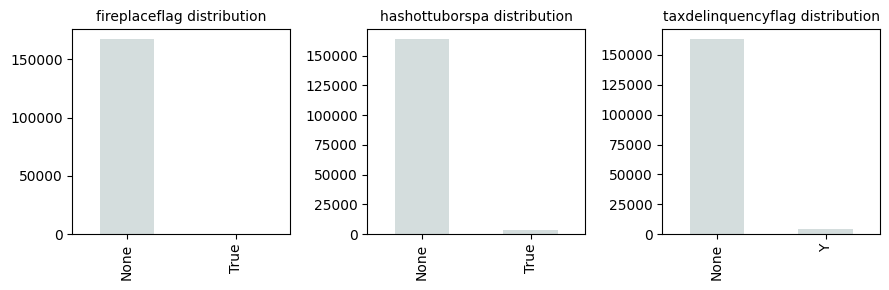

In [ ]:
#可視化
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9,3))
for i, col in enumerate(na_obj):
    data[col].value_counts().plot.bar(ax = ax[i], color = '#d4dddd')
    ax[i].set_title(f'{col} distribution', fontsize = 10);
plt.tight_layout()
plt.show()

ここで、変数`finishedsquarefeet**`について考察してみる。これらの変数は、施工後の特定のfeetごとの物件の総面積と考えられる。以下の図のように12feet級の物件が多く、それ以外の物件は欠損値が多い、つまり広い総面積の物件の絶対数はかなり少ないことが分かる。対して変数`calculatedfinishedsquarefeet`は完成後の物件の総面積であり、これを物件の面積の指標の代表として活用するようにする。それ以外は、欠損値が多く極端であり、似たような性質を持つカラムをモデルの特徴量にすると多重共線性の可能性があるためデータセットから削除する。

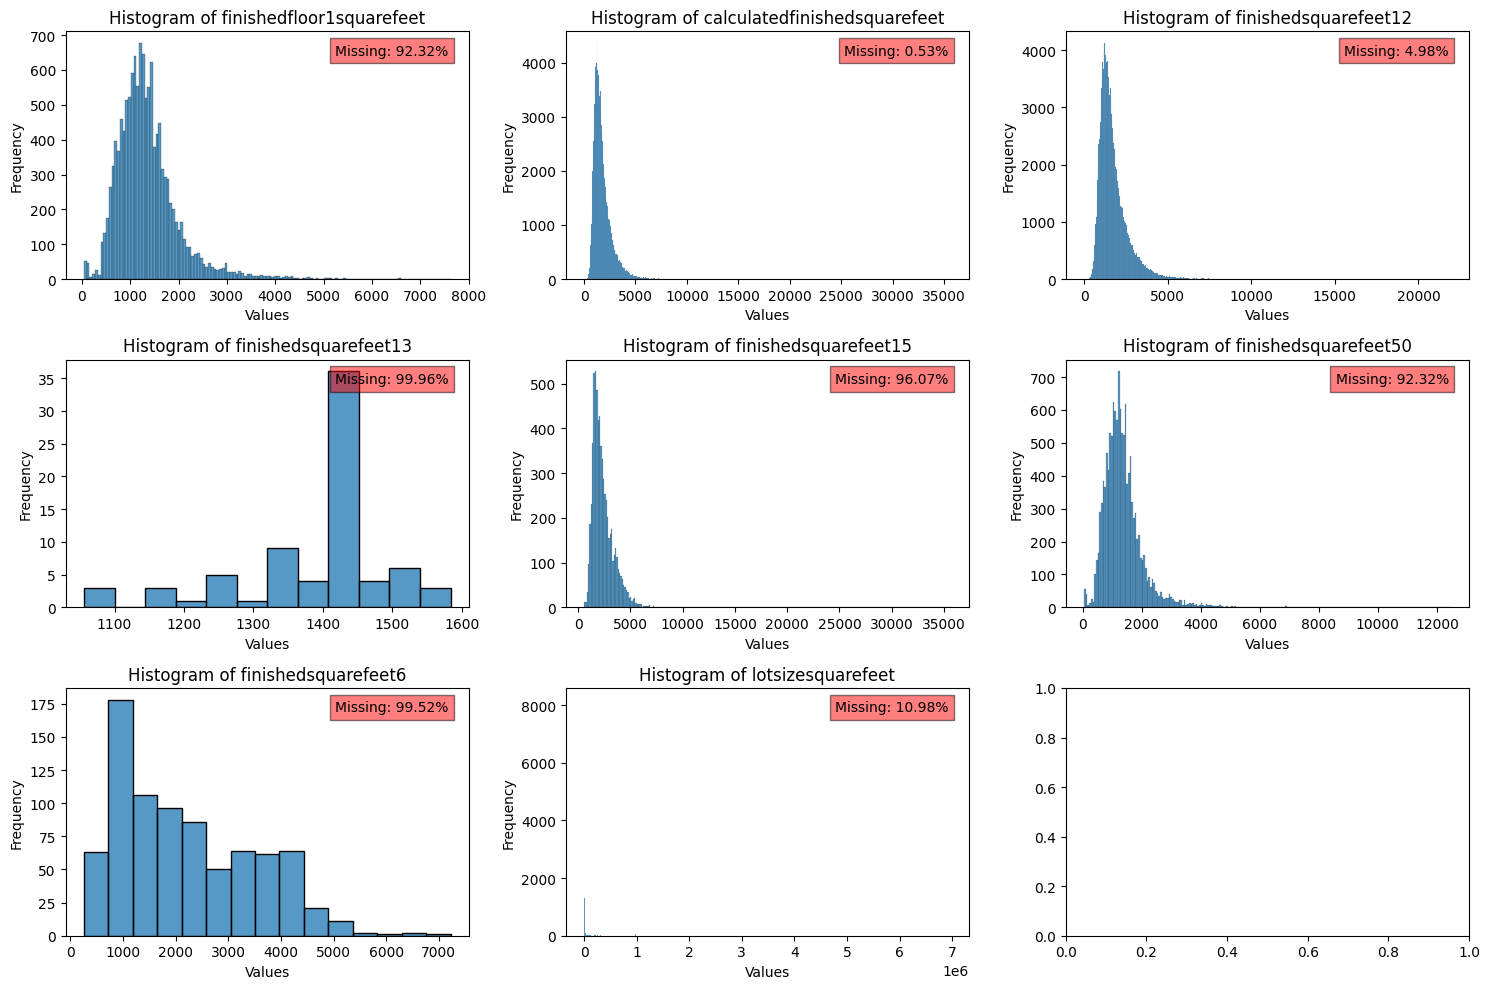

In [ ]:
def plot_histogram(data, column_name, ax):
    sns.histplot(data[column_name], ax=ax)
    ax.set_title("Histogram of " + column_name)
    ax.set_xlabel("Values")
    ax.set_ylabel("Frequency")

    # 欠損値の割合を計算
    missing_percentage = data[column_name].isnull().mean() * 100
    
    # 欠損値の割合を表示
    ax.text(0.95, 0.95, f"Missing: {missing_percentage:.2f}%", 
            transform=ax.transAxes, ha='right', va='top', 
            bbox=dict(facecolor='red', alpha=0.5))

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

# column_names = [x for x in data.columns if x.startswith('finishedsquarefeet')]
to_drop = data.filter(like='squarefeet')
to_drop = to_drop.columns

for i, column_name in enumerate(to_drop):
    plot_histogram(data, column_name, axes[i])

plt.tight_layout()
plt.show()


変数`calculatedfinishedsquarefeet`以外のsquarefeet関連の変数はすべて削除する。

In [ ]:
to_drop = data.filter(like='squarefeet')
to_drop = list(to_drop.columns)
to_drop.remove('calculatedfinishedsquarefeet')
data.drop(to_drop, axis=1, inplace=True) #axis=1 の付け忘れに注意

変数`parcelid`は一意のidでありモデルの特徴量として削除しても差し支えないと考えられるので削除する。

In [ ]:
data.drop('parcelid', axis=1, inplace=True)

変数`missing_09`から先ほどの変数`to_drop`を除外する。

In [ ]:
missing_09 = list(set(missing_09) - set(to_drop))

変数`na_float`は、変数`missing_float`のうちfloat型のカラムを指す。

In [ ]:
na_float = data[missing_09].select_dtypes('float').columns
na_float
# data.drop(na_float, axis=1, inplace=True)


Index(['buildingclasstypeid', 'poolsizesum', 'basementsqft',
       'yardbuildingsqft26', 'architecturalstyletypeid', 'taxdelinquencyyear',
       'decktypeid', 'pooltypeid10', 'pooltypeid2', 'typeconstructiontypeid',
       'yardbuildingsqft17', 'storytypeid'],
      dtype='object')

変数`na_float`は欠損値が9割以上を占めるfloat型の変数の集まりであり、有用性はないので削除する。

In [ ]:
data[na_float].isna().sum().sort_values(ascending=False)/len(data[na_float])

buildingclasstypeid         0.999815
basementsqft                0.999446
storytypeid                 0.999446
yardbuildingsqft26          0.999017
architecturalstyletypeid    0.997212
typeconstructiontypeid      0.996891
decktypeid                  0.992424
pooltypeid10                0.990315
poolsizesum                 0.989052
pooltypeid2                 0.986431
taxdelinquencyyear          0.972106
yardbuildingsqft17          0.969986
dtype: float64

In [ ]:
data.drop(na_float, axis=1, inplace=True)

再び、過度な欠損値を含む変数を除外したデータセットの変数の欠損値の状態を見てみる。

In [ ]:
na_ratio = data.isna().sum().sort_values(ascending=False)/len(data)
na_ratio

fireplacecnt                    0.893405
threequarterbathnbr             0.868275
pooltypeid7                     0.810731
poolcnt                         0.797037
numberofstories                 0.772652
airconditioningtypeid           0.679620
garagecarcnt                    0.669679
garagetotalsqft                 0.669679
regionidneighborhood            0.601008
heatingorsystemtypeid           0.370705
buildingqualitytypeid           0.361640
propertyzoningdesc              0.352014
unitcnt                         0.350424
regionidcity                    0.019710
fullbathcnt                     0.010912
calculatedbathnbr               0.010912
yearbuilt                       0.006314
calculatedfinishedsquarefeet    0.005337
censustractandblock             0.005277
structuretaxvaluedollarcnt      0.003151
regionidzip                     0.000709
taxamount                       0.000268
landtaxvaluedollarcnt           0.000220
taxvaluedollarcnt               0.000214
propertycountyla

idを含むカラムについて考察する。

In [ ]:
# "id"を含むカラムのみを抽出
id_columns = data.filter(like='id', axis=1).columns

In [ ]:
id_columns

Index(['airconditioningtypeid', 'buildingqualitytypeid',
       'heatingorsystemtypeid', 'pooltypeid7', 'propertylandusetypeid',
       'regionidcity', 'regionidcounty', 'regionidneighborhood',
       'regionidzip'],
      dtype='object')

カラム名にidとつく場合は欠損値の置き換え方に注意が必要である。なぜなら、単純に平均で置き換えると実際には使用されていないidが割り振られてしまう可能性があるからである。

idに関するカラムの一意な値の個数と欠損値の確認をすると、変数`pooltypeid7`は一種類しか値がなく、欠損値も大きいことからモデルの精度に寄与しないと考えられる。よって、削除する。

In [ ]:
# idに関するカラムの一意な値の個数と欠損値の確認
na_ratio = data[id_columns].isna().sum().sort_values(ascending=False)/len(data)
na_ratio
for col in id_columns:
    print(f'{col}\n', 'n_unique:', data[col].nunique(), '\tna_ratio:', na_ratio[col])
    print("")

airconditioningtypeid
 n_unique: 6 	na_ratio: 0.6796197464976651

buildingqualitytypeid
 n_unique: 12 	na_ratio: 0.36163990279233776

heatingorsystemtypeid
 n_unique: 12 	na_ratio: 0.37070547031354234

pooltypeid7
 n_unique: 1 	na_ratio: 0.8107309634994758

propertylandusetypeid
 n_unique: 14 	na_ratio: 0.0002025159630229677

regionidcity
 n_unique: 178 	na_ratio: 0.01970956828361765

regionidcounty
 n_unique: 3 	na_ratio: 0.0002025159630229677

regionidneighborhood
 n_unique: 505 	na_ratio: 0.601007814733632

regionidzip
 n_unique: 390 	na_ratio: 0.0007088058705803869



In [ ]:
data.drop('pooltypeid7', axis=1, inplace=True)

In [ ]:
id_columns = id_columns.drop('pooltypeid7')

In [ ]:
# # 各カラムの一意な値の種類と個数を表示
# for col in id_columns:
#     val_cnt = data[col].value_counts()
#     print(f"Column: {col}")
#     print(f"n_unique: {data[col].nunique()}")
#     print(val_cnt)
#     print()

変数`id_columns`の対象のカラムの欠損値を頻出値で置き換える。

In [ ]:
data[id_columns].mode().iloc[0]

airconditioningtypeid        1.0
buildingqualitytypeid        7.0
heatingorsystemtypeid        2.0
propertylandusetypeid      261.0
regionidcity             12447.0
regionidcounty            3101.0
regionidneighborhood     27080.0
regionidzip              97319.0
Name: 0, dtype: float64

In [ ]:
_data = data.copy()

In [ ]:
# data = _data.copy()

In [ ]:
data[id_columns] = data[id_columns].fillna(data[id_columns].mode().iloc[0])

ここまでのカラムの欠損値の割合を表示

In [ ]:
na_ratio = data.isna().sum().sort_values(ascending=False)/len(data)
na_ratio

fireplacecnt                    0.893405
threequarterbathnbr             0.868275
poolcnt                         0.797037
numberofstories                 0.772652
garagetotalsqft                 0.669679
garagecarcnt                    0.669679
propertyzoningdesc              0.352014
unitcnt                         0.350424
calculatedbathnbr               0.010912
fullbathcnt                     0.010912
yearbuilt                       0.006314
calculatedfinishedsquarefeet    0.005337
censustractandblock             0.005277
structuretaxvaluedollarcnt      0.003151
taxamount                       0.000268
landtaxvaluedollarcnt           0.000220
taxvaluedollarcnt               0.000214
propertycountylandusecode       0.000208
fips                            0.000203
latitude                        0.000203
longitude                       0.000203
bedroomcnt                      0.000203
rawcensustractandblock          0.000203
bathroomcnt                     0.000203
roomcnt         

In [ ]:
na_ratio[na_ratio>0]

fireplacecnt                    0.893405
threequarterbathnbr             0.868275
poolcnt                         0.797037
numberofstories                 0.772652
garagetotalsqft                 0.669679
garagecarcnt                    0.669679
propertyzoningdesc              0.352014
unitcnt                         0.350424
calculatedbathnbr               0.010912
fullbathcnt                     0.010912
yearbuilt                       0.006314
calculatedfinishedsquarefeet    0.005337
censustractandblock             0.005277
structuretaxvaluedollarcnt      0.003151
taxamount                       0.000268
landtaxvaluedollarcnt           0.000220
taxvaluedollarcnt               0.000214
propertycountylandusecode       0.000208
fips                            0.000203
latitude                        0.000203
longitude                       0.000203
bedroomcnt                      0.000203
rawcensustractandblock          0.000203
bathroomcnt                     0.000203
roomcnt         

次に、cntとそうでないカラムの二パターンに分けて考えてみる。cntは個体の数え値であると思われる。

In [ ]:
#欠損値を含む変数を抽出
na_cols = na_ratio[na_ratio>0].index
na_cols

Index(['fireplacecnt', 'threequarterbathnbr', 'poolcnt', 'numberofstories',
       'garagetotalsqft', 'garagecarcnt', 'propertyzoningdesc', 'unitcnt',
       'calculatedbathnbr', 'fullbathcnt', 'yearbuilt',
       'calculatedfinishedsquarefeet', 'censustractandblock',
       'structuretaxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt',
       'taxvaluedollarcnt', 'propertycountylandusecode', 'fips', 'latitude',
       'longitude', 'bedroomcnt', 'rawcensustractandblock', 'bathroomcnt',
       'roomcnt', 'assessmentyear'],
      dtype='object')

In [ ]:
# ends with 'cnt'
na_cnt = na_cols[na_cols.str.endswith('cnt')]
na_others = na_cols[~na_cols.str.endswith('cnt')]
print("na_cnt \n", na_cnt)
print("na_others \n", na_others)

na_cnt 
 Index(['fireplacecnt', 'poolcnt', 'garagecarcnt', 'unitcnt', 'fullbathcnt',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'taxvaluedollarcnt', 'bedroomcnt', 'bathroomcnt', 'roomcnt'],
      dtype='object')
na_others 
 Index(['threequarterbathnbr', 'numberofstories', 'garagetotalsqft',
       'propertyzoningdesc', 'calculatedbathnbr', 'yearbuilt',
       'calculatedfinishedsquarefeet', 'censustractandblock', 'taxamount',
       'propertycountylandusecode', 'fips', 'latitude', 'longitude',
       'rawcensustractandblock', 'assessmentyear'],
      dtype='object')


カラム名にcntを含むカラムを変数`na_cnt`に格納し、一意な値の種類と欠損値の含有率を表示。`fireplacement`と`poolcnt`は欠損値が多く一意な値が一つまたは少ないため特徴量として寄与しにくいので削除する。その他のカラムの欠損値は頻出値で置き換える。

In [ ]:
for col in na_cnt:
    print(f'{col}  d_type:{data[col].dtype}\n', 'n_unique:', data[col].nunique(), '\tna_ratio:', na_ratio[col])
    print("")

fireplacecnt  d_type:float64
 n_unique: 5 	na_ratio: 0.8934051272276756

poolcnt  d_type:float64
 n_unique: 1 	na_ratio: 0.7970373105880111

garagecarcnt  d_type:float64
 n_unique: 15 	na_ratio: 0.6696785952539789

unitcnt  d_type:float64
 n_unique: 13 	na_ratio: 0.3504240922519775

fullbathcnt  d_type:float64
 n_unique: 16 	na_ratio: 0.010912036595825788

structuretaxvaluedollarcnt  d_type:float64
 n_unique: 96512 	na_ratio: 0.003150910130563233

landtaxvaluedollarcnt  d_type:float64
 n_unique: 102189 	na_ratio: 0.00022038501858381778

taxvaluedollarcnt  d_type:float64
 n_unique: 102170 	na_ratio: 0.0002144286667302011

bedroomcnt  d_type:float64
 n_unique: 17 	na_ratio: 0.0002025159630229677

bathroomcnt  d_type:float64
 n_unique: 25 	na_ratio: 0.0002025159630229677

roomcnt  d_type:float64
 n_unique: 17 	na_ratio: 0.0002025159630229677



In [ ]:
data.drop(['fireplacecnt','poolcnt'], axis=1, inplace=True)
na_cnt = na_cnt.drop(['fireplacecnt','poolcnt'])
data.fillna(data[na_cnt].mode().iloc[0], inplace=True)

その他のカラムも同様に処理する。

In [ ]:
for col in na_others:
    print(f'{col}  d_type:{data[col].dtype}\n', 'n_unique:', data[col].nunique(), '\tna_ratio:', na_ratio[col])
    print("")

threequarterbathnbr  d_type:float64
 n_unique: 5 	na_ratio: 0.8682752787572667

numberofstories  d_type:float64
 n_unique: 5 	na_ratio: 0.7726520060993043

garagetotalsqft  d_type:float64
 n_unique: 1035 	na_ratio: 0.6696785952539789

propertyzoningdesc  d_type:object
 n_unique: 2346 	na_ratio: 0.35201443819689315

calculatedbathnbr  d_type:float64
 n_unique: 24 	na_ratio: 0.010912036595825788

yearbuilt  d_type:float64
 n_unique: 138 	na_ratio: 0.006313732964833699

calculatedfinishedsquarefeet  d_type:float64
 n_unique: 5825 	na_ratio: 0.00533689126084056

censustractandblock  d_type:float64
 n_unique: 57544 	na_ratio: 0.005277327742304393

taxamount  d_type:float64
 n_unique: 149915 	na_ratio: 0.00026803583341275137

propertycountylandusecode  d_type:object
 n_unique: 90 	na_ratio: 0.00020847231487658438

fips  d_type:float64
 n_unique: 3 	na_ratio: 0.0002025159630229677

latitude  d_type:float64
 n_unique: 126379 	na_ratio: 0.0002025159630229677

longitude  d_type:float64
 n_unique

In [ ]:
data.drop(['threequarterbathnbr', 'numberofstories'], axis=1, inplace=True)
na_others = na_others.drop(['threequarterbathnbr', 'numberofstories'])
data.fillna(data[na_others].mode().iloc[0], inplace=True)

In [ ]:
data.isna().sum()

logerror                        0
transactiondate                 0
airconditioningtypeid           0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
hashottuborspa                  0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
propertycountylandusecode       0
propertylandusetypeid           0
propertyzoningdesc              0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidneighborhood            0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
fireplaceflag                   0
structuretaxvaluedollarcnt      0
taxvaluedollar

na_cnt に入っているカラム

In [ ]:
# fireplacecnt: ファイヤープレイス（暖炉）の数
# poolcnt: プールの数
# garagecarcnt: ガレージの収容可能な車両数
# unitcnt: 物件のユニット数
# fullbathcnt: フルバスルームの数
# structuretaxvaluedollarcnt: 建物の評価額（ドル）
# landtaxvaluedollarcnt: 土地の評価額（ドル）
# taxvaluedollarcnt: 不動産の評価額（ドル）
# bedroomcnt: ベッドルームの数
# bathroomcnt: バスルームの数
# roomcnt: 部屋の総数

na_othersに入っているカラム

In [ ]:
# threequarterbathnbr: 3/4バスルームの数
# numberofstories: 建物の階数
# garagetotalsqft: ガレージの総面積（平方フィート）
# propertyzoningdesc: 物件のゾーニングコード（地域の用途や制限を示すコード）
# calculatedbathnbr: 計算されたバスルームの数
# yearbuilt: 建物の築年数
# calculatedfinishedsquarefeet: 計算された建物の総面積（平方フィート）
# censustractandblock: 国勢調査トラクトとブロックグループの識別子
# taxamount: 不動産税額
# propertycountylandusecode: 物件の郡の土地利用コード
# rawcensustractandblock: 加工されていない国勢調査トラクトとブロックグループの識別子
# assessmentyear: 評価年
# longitude: 物件の経度
# latitude: 物件の緯度
# fips: 物件の連邦情報処理基準コード（地域を識別するための番号）

datatime64型のカラムの処理を行う。以下のように、`year`,`month`,`day`,`weekday`に分解して特徴量として加える。

In [ ]:
data['transactiondate'] = pd.to_datetime(data['transactiondate'], format = '%Y-%m-%d')

data['year'] = data['transactiondate'].dt.year
data['month'] = data['transactiondate'].dt.month
data['day'] = data['transactiondate'].dt.day
data['weekday'] = data['transactiondate'].dt.weekday
data.drop('transactiondate', axis=1, inplace=True)

In [ ]:
data.dtypes.value_counts()

float64    29
object      5
int64       4
dtype: int64

データセット全体を眺めてみる。

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   logerror                      167888 non-null  float64
 1   airconditioningtypeid         167888 non-null  float64
 2   bathroomcnt                   167888 non-null  float64
 3   bedroomcnt                    167888 non-null  float64
 4   buildingqualitytypeid         167888 non-null  float64
 5   calculatedbathnbr             167888 non-null  float64
 6   calculatedfinishedsquarefeet  167888 non-null  float64
 7   fips                          167888 non-null  float64
 8   fullbathcnt                   167888 non-null  float64
 9   garagecarcnt                  167888 non-null  float64
 10  garagetotalsqft               167888 non-null  float64
 11  hashottuborspa                167888 non-null  object 
 12  heatingorsystemtypeid         167888 non-nul

最後に、カテゴリカルなカラムをエンコードする。

In [ ]:
data.columns

Index(['logerror', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock',
       'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
       'roomcnt', 'unitcnt', 'yearbuilt', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'censustractandblock', 'year', 'month', 'day', 'weekday'],
      dtype='object')

カラムが表す情報について記載する。

In [ ]:
# 'logerror': この列は、予測価格と実際の価格との差を表す対数誤差を示します。不動産の予測モデルの精度を評価するために使用されます。

# 'airconditioningtypeid': この列は、物件に設置されている空調システムのタイプを示します。 //

# 'bathroomcnt': この列は、物件のバスルームの数を示します。

# 'bedroomcnt': この列は、物件の寝室の数を示します。

# 'buildingqualitytypeid': この列は、建物の品質を示す指標です。 //

# 'calculatedbathnbr': この列は、物件の浴室の数を示します。

# 'calculatedfinishedsquarefeet': この列は、物件の計算された完成した床面積を示します。

# 'fips': この列は、物件の郡の連邦情報処理標準コードを示します。 //

# 'fullbathcnt': この列は、物件のフルバスルームの数を示します。

# 'garagecarcnt': この列は、物件のガレージの車両収容台数を示します。

# 'garagetotalsqft': この列は、物件のガレージの総面積を示します。

# 'hashottuborspa': この列は、物件にホットタブまたはスパがあるかどうかを示します。 //

# 'heatingorsystemtypeid': この列は、物件に設置されている暖房システムのタイプを示します。 //

# 'latitude': この列は、物件の緯度座標を示します。

# 'longitude': この列は、物件の経度座標を示します。

# 'propertycountylandusecode': この列は、物件の郡の土地利用コードを示します。 //

# 'propertylandusetypeid': この列は、物件の用途を示すコードです。 //

# 'propertyzoningdesc': この列は、物件の地域のゾーニングコードや用途に関する説明を示します。 //

# 'rawcensustractandblock': この列は、国勢調査のトラクトとブロックの識別子を示します。 //

# 'regionidcity': この列は、物件が所在する都市の識別子を示します。 //

# 'regionidcounty': この列は、物件が所在する郡の識別子を示します。 //

# 'regionidneighborhood': この列は、物件が所在する近隣地域の識別子を示します。 //

# 'regionidzip': この列は、物件が所在する郵便番号の識別子 //

# 'roomcnt': この列は、物件の部屋の総数を示します。

# 'unitcnt': この列は、物件内のユニット（住宅やアパートなどの独立した住居単位）の数を示します。

# 'yearbuilt': この列は、物件の建築年を示します。

# 'fireplaceflag': この列は、物件に暖炉があるかどうかを示すフラグです。 //

# 'structuretaxvaluedollarcnt': この列は、物件の建物構造の評価額を示します。

# 'taxvaluedollarcnt': この列は、物件の総評価額を示します。

# 'assessmentyear': この列は、物件の評価年を示します。

# 'landtaxvaluedollarcnt': この列は、物件の土地の評価額を示します。

# 'taxamount': この列は、物件の税金額を示します。

# 'taxdelinquencyflag': この列は、物件の税金未納状態を示すフラグです。 //

# 'censustractandblock': この列は、国勢調査のトラクトとブロックの識別子を示します。 //

# 'year': この列は、日付データの年を示します。

# 'month': この列は、日付データの月を示します。

# 'day': この列は、日付データの日を示します。

# 'weekday': この列は、日付データの曜日を示します。

カテゴリカルなカラム(ex: id, タイプ, 個体の種類など)を抽出し、それらをワンホットエンコーディングする。

In [ ]:
# 'airconditioningtypeid': この列は、物件に設置されている空調システムのタイプを示します。 //
# 'buildingqualitytypeid': この列は、建物の品質を示す指標です。 //
# 'fips': この列は、物件の郡の連邦情報処理標準コードを示します。 //
# 'hashottuborspa': この列は、物件にホットタブまたはスパがあるかどうかを示します。 //
# 'heatingorsystemtypeid': この列は、物件に設置されている暖房システムのタイプを示します。 //
# 'propertycountylandusecode': この列は、物件の郡の土地利用コードを示します。 //
# 'propertylandusetypeid': この列は、物件の用途を示すコードです。 //
# 'propertyzoningdesc': この列は、物件の地域のゾーニングコードや用途に関する説明を示します。 //
# 'rawcensustractandblock': この列は、国勢調査のトラクトとブロックの識別子を示します。 //
# 'regionidcity': この列は、物件が所在する都市の識別子を示します。 //
# 'regionidcounty': この列は、物件が所在する郡の識別子を示します。 //
# 'regionidneighborhood': この列は、物件が所在する近隣地域の識別子を示します。 //
# 'regionidzip': この列は、物件が所在する郵便番号の識別子 //
# 'fireplaceflag': この列は、物件に暖炉があるかどうかを示すフラグです。 //
# 'taxdelinquencyflag': この列は、物件の税金未納状態を示すフラグです。 //
# 'censustractandblock': この列は、国勢調査のトラクトとブロックの識別子を示します。 //

In [ ]:
to_encode_col = [
'airconditioningtypeid',
'buildingqualitytypeid',
'fips',
'hashottuborspa',
'heatingorsystemtypeid',
'propertycountylandusecode',
'propertylandusetypeid',
'propertyzoningdesc',
'rawcensustractandblock',
'regionidcity',
'regionidcounty',
'regionidneighborhood',
'regionidzip',
'fireplaceflag',
'taxdelinquencyflag',
'censustractandblock']

続いて、エンコーダであるが、すべてワンホットエンコードすると生成される特徴量が膨大になるのでラベルエンコードを採用する。与えられたカテゴリカルなカラムは数字で与えられているので、文字列やboolで与えられたカラムのみラベルエンコードを適用する。

以下の通り,、`hashottuborspa`, `fireplaceflag`, `taxdelinquencyflag`にラベルエンコードを適用させる。

In [ ]:
for col in to_encode_col:
        unique_values = data[col].unique()
        if data[col].nunique()<10:
            print(f"{col}: {unique_values}")
            print('')

airconditioningtypeid: [ 1.  5. 13. 11.  9.  3.]

fips: [6037. 6059. 6111.]

hashottuborspa: ['None' True]

regionidcounty: [3101. 1286. 2061.]

fireplaceflag: ['None' True]

taxdelinquencyflag: ['None' 'Y']



Trueを'True'に置き換える。

In [ ]:
data[['hashottuborspa', 'fireplaceflag']] = data[['hashottuborspa', 'fireplaceflag']].replace({True:'True', True:'True'})

In [ ]:
for col in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

残りのカテゴリカルなカラムのエンコードを行う。

In [ ]:
for col in to_encode_col:
    if data[col].dtype == 'object':
        print(f'col_name:{col}  ' ,data[col].nunique())
        print(data[col])

col_name:propertycountylandusecode   90
0         0100
1            1
2         0100
3         010C
4          122
          ... 
167883    010C
167884    0100
167885    1111
167886    0100
167887    0100
Name: propertycountylandusecode, Length: 167888, dtype: object
col_name:propertyzoningdesc   2346
0              LARS
1              LAR1
2              PSR6
3              LAR3
4              LAR1
            ...    
167883        LARD3
167884       LARE40
167885         LAR1
167886        SER1*
167887    WHR16000*
Name: propertyzoningdesc, Length: 167888, dtype: object


In [ ]:
for col in to_encode_col:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

カテゴリカルなカラムのエンコードのすべてを完了した。

In [ ]:
for col in to_encode_col:
        unique_values = data[col].unique()
        print(f"{col}: {unique_values}")
        print('')

airconditioningtypeid: [ 1.  5. 13. 11.  9.  3.]

buildingqualitytypeid: [ 4.  7.  1. 12. 10.  8.  6. 11.  9.  5.  3.  2.]

fips: [6037. 6059. 6111.]

hashottuborspa: [0 1]

heatingorsystemtypeid: [ 2.  7.  6. 24. 13. 20. 18. 11.  1. 14. 12. 10.]

propertycountylandusecode: [ 2 55 10 71 68 84 67 12  6  3 35 53 62 31 11 61 47 24 18 64 33 14 43 13
 65  5 85 70 20 17 89 76  8 59 63 36  9 73 15 77 72 74 81 57 80 48  4 25
 87 60 19 56 27 88 45 42 58 75 22 32 40 49 26 41 52 54 69 46 82 86 79  1
 83  0 78 28 44 34 38 21 29 51 66  7 30 23 16 50 37 39]

propertylandusetypeid: [261. 266. 265. 246. 263. 269. 248. 247. 267. 275. 260.  31. 264.  47.]

propertyzoningdesc: [ 752  717 1793 ... 1112 1152  145]

rawcensustractandblock: [60371066.461001 60590524.222024 60374638.003004 ... 60371872.001002
 60373016.012029 60374022.003025]

regionidcity: [ 12447.  32380.  47019.  17686.  29712.  24174.  13150.  25459.  46098.
 396054.  52650.  17150.  25218.  53655.  46298.  34780.  47568.  24832.
   5465.

In [ ]:
import pickle

データ前加工の一連の処理をしたファイルを保存およびダウンロード

In [ ]:
#　w,w+ はファイルをすべて初期化してサイズ0にするので要注意。
# myfile = open("/content/drive/MyDrive/kaggle/zillow_prize/datasets/processing/data_230602.pickle", "w+")

In [ ]:
pd.to_pickle(data, "/content/drive/MyDrive/kaggle/zillow_prize/datasets/processing/data_230602.pickle")

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/kaggle/zillow_prize/datasets/processing/data_230602.pickle")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 38 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   logerror                      167888 non-null  float64
 1   airconditioningtypeid         167888 non-null  float64
 2   bathroomcnt                   167888 non-null  float64
 3   bedroomcnt                    167888 non-null  float64
 4   buildingqualitytypeid         167888 non-null  float64
 5   calculatedbathnbr             167888 non-null  float64
 6   calculatedfinishedsquarefeet  167888 non-null  float64
 7   fips                          167888 non-null  float64
 8   fullbathcnt                   167888 non-null  float64
 9   garagecarcnt                  167888 non-null  float64
 10  garagetotalsqft               167888 non-null  float64
 11  hashottuborspa                167888 non-null  int64  
 12  heatingorsystemtypeid         167888 non-nul

ここまでは、欠損値処理と年、月、日の特徴量の追加を行いました。

##EDA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167888 entries, 0 to 77612
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   parcelid                      167888 non-null  int64         
 1   logerror                      167888 non-null  float64       
 2   transactiondate               167888 non-null  datetime64[ns]
 3   airconditioningtypeid         167888 non-null  float64       
 4   bathroomcnt                   167888 non-null  float64       
 5   bedroomcnt                    167888 non-null  float64       
 6   buildingqualitytypeid         167888 non-null  float64       
 7   calculatedbathnbr             167888 non-null  float64       
 8   calculatedfinishedsquarefeet  167888 non-null  float64       
 9   finishedsquarefeet12          167888 non-null  float64       
 10  fips                          167888 non-null  float64       
 11  fireplacecnt  

<ipython-input-22-d787d6c38484>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['logerror'], color = '#004c70')


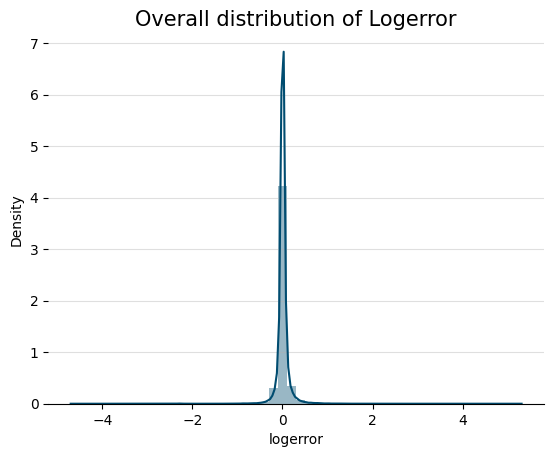

In [ ]:
ax = plt.subplot(1,1,1)
sns.distplot(data['logerror'], color = '#004c70')
plt.title('Overall distribution of Logerror', fontsize = 15)

for s in ['top','left','right']:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)
plt.show()

<ipython-input-23-09610108de80>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data2016['logerror'], color = '#004c70')
<ipython-input-23-09610108de80>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data2017['logerror'], color = '#990000')


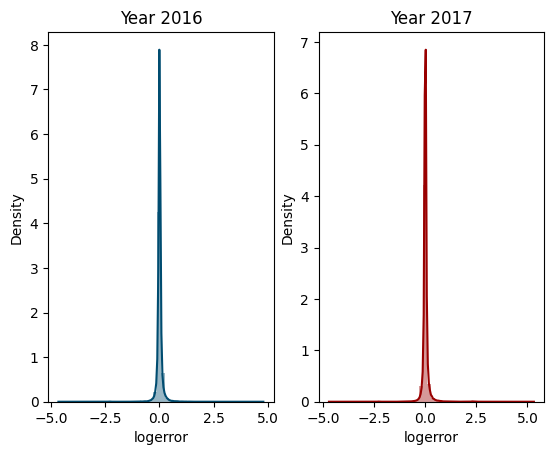

In [ ]:
plt.subplot(1,2,1)
sns.distplot(data2016['logerror'], color = '#004c70')
plt.title('Year 2016')
plt.subplot(1,2,2)
sns.distplot(data2017['logerror'], color = '#990000')
plt.title('Year 2017')
plt.show()

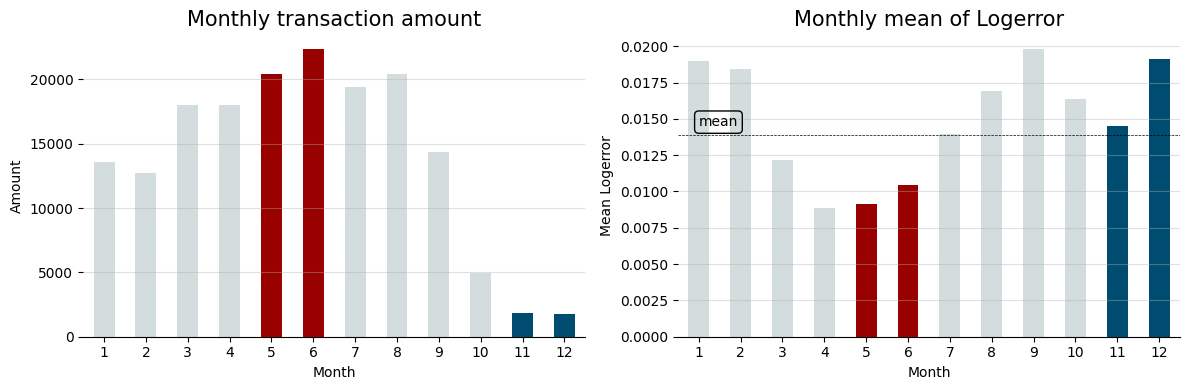

In [ ]:
color_map = ['#d4dddd' for _ in range(12)]
color_map[10] = color_map[11] = '#004c70'; color_map[4] = color_map[5] = '#990000'


plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('month')['logerror'].count().plot.bar(color = color_map)
plt.xticks(rotation = 0); plt.xlabel('Month'); plt.ylabel('Amount')
plt.title('Monthly transaction amount', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)


ax2 = plt.subplot(1,2,2)
data.groupby('month')['logerror'].mean().plot.bar(color = color_map)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(0, 0.0145, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(rotation = 0); plt.xlabel('Month'); plt.ylabel('Mean Logerror')
plt.title('Monthly mean of Logerror', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

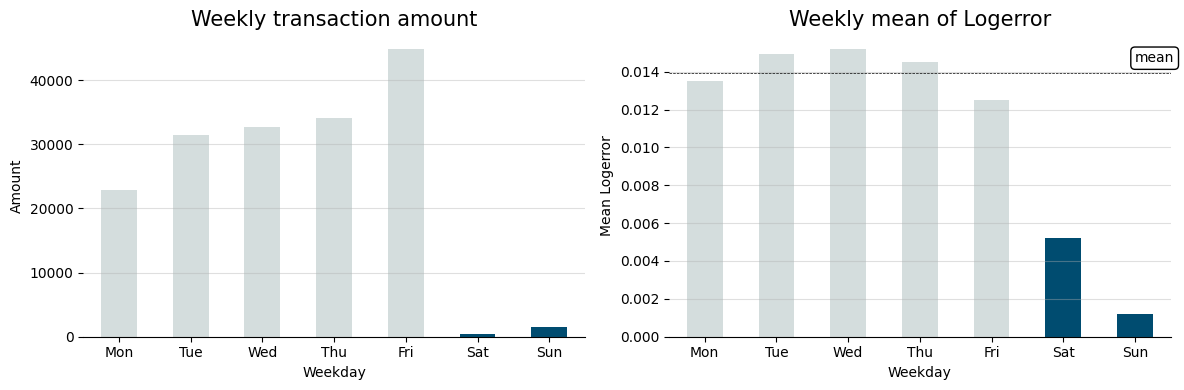

In [ ]:
color_map = ['#d4dddd' for _ in range(7)]
color_map[5] = color_map[6] = '#004c70'

plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
data.groupby('weekday')['logerror'].count().plot.bar(color = color_map)
plt.xticks(range(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation = 0); plt.xticks(rotation = 0); plt.xlabel('Weekday'); plt.ylabel('Amount')
plt.title('Weekly transaction amount', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)



ax = plt.subplot(1,2,2)
data.groupby('weekday')['logerror'].mean().plot.bar(color = color_map)
plt.axhline(data['logerror'].mean(), linestyle = '--', color = 'black', linewidth = 0.5)
plt.text(6, 0.0145, 'mean', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.xticks(range(0,7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation = 0); plt.xlabel('Weekday'); plt.ylabel('Mean Logerror')
plt.title('Weekly mean of Logerror', fontsize = 15)


# axis setting
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

In [ ]:
# yearbuilt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   yearbuilt  139 non-null    float64
 1   logerror   139 non-null    float64
dtypes: float64(2)
memory usage: 2.3 KB


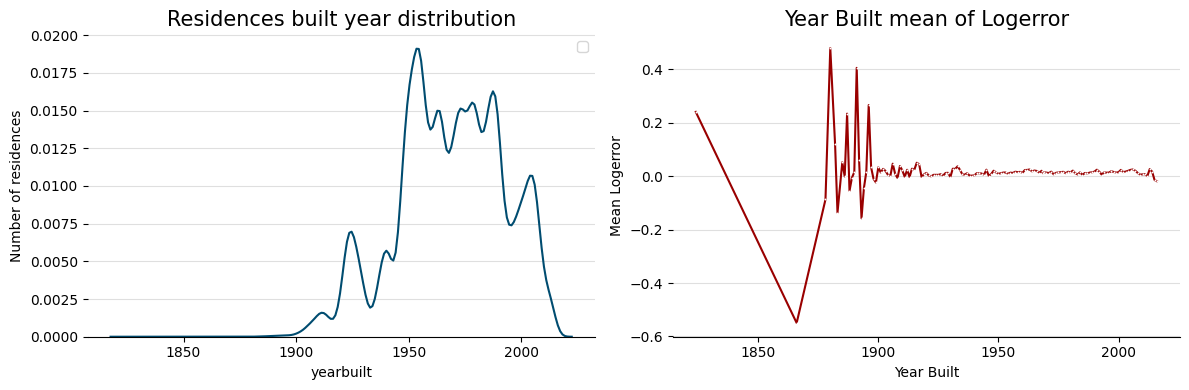

In [ ]:
plt.figure(figsize = (12,4))
ax1 = plt.subplot(1,2,1)
sns.kdeplot(data['yearbuilt'], color = '#004c70');plt.legend(loc='best'); plt.ylabel('Number of residences')
plt.title('Residences built year distribution', fontsize = 15)

# axis setting
for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.4)

ax2 = plt.subplot(1,2,2)
yearbuilt = data.groupby(['yearbuilt'])['logerror'].mean().reset_index()
sns.lineplot(data = yearbuilt, x = 'yearbuilt', y = 'logerror', marker = 'o', markersize = 0.6, color = '#990000')
plt.xticks([1850, 1900, 1950, 2000]); plt.xlabel('Year Built'); plt.ylabel('Mean Logerror')
plt.title('Year Built mean of Logerror', fontsize = 15)
# axis setting
for s in ["top","right","left"]:
    ax2.spines[s].set_visible(False)
ax2.grid(axis='y', linestyle='-', alpha=0.4)

plt.tight_layout()

In [ ]:
data[['latitude','longitude']] = data[['latitude','longitude']]/1000000

In [ ]:
# convert to categorical variable
new_cat = []
for value in data['regionidcounty'].values:
    if value == 1286:
        new_cat.append('Orange')
    elif value == 2061:
        new_cat.append('Ventura')
    else:
        new_cat.append('LA')

data['regionidcounty'] = new_cat

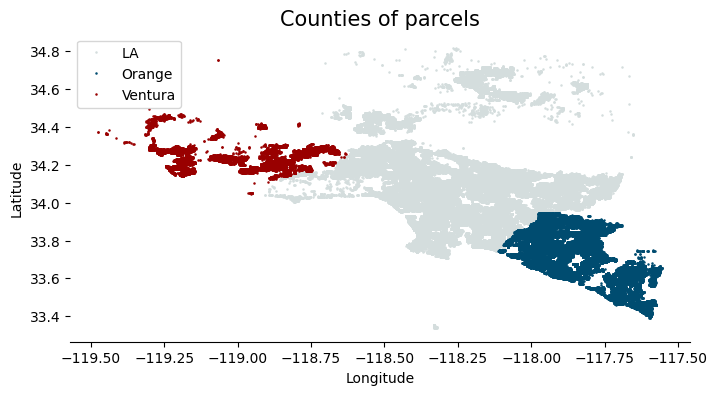

In [ ]:
# county
colors = ['#d4dddd','#004c70', '#990000'] # originally 3, but includes NA values

plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
for i, c in enumerate(data['regionidcounty'].unique()):
    df = data[data['regionidcounty']==c]
    plt.plot(df['longitude'], df['latitude'], 'o', markersize = 0.8, color = colors[i], label = c)
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Counties of parcels', fontsize = 15); plt.legend(loc = 'best')
    
for s in ["top","right","left"]:
    ax.spines[s].set_visible(False)

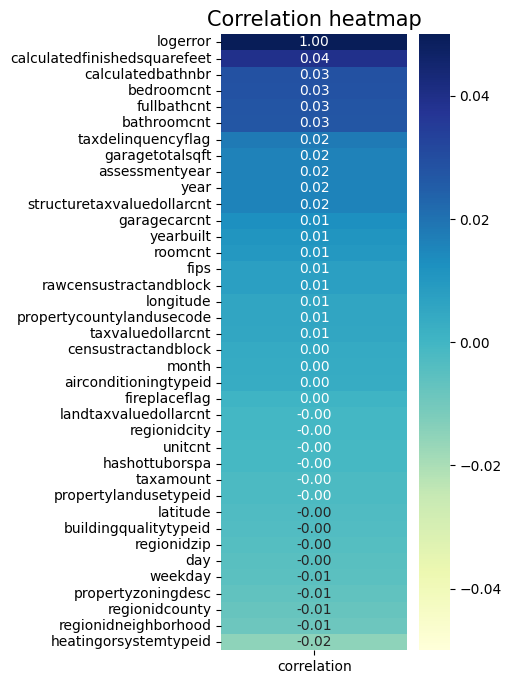

In [27]:
corr = pd.DataFrame(data.corr()['logerror'].sort_values(ascending = False)).rename(columns = {'logerror':'correlation'})

plt.figure(figsize = (3,8))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'YlGnBu')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

## 前処理したデータの読み込み

In [4]:
data = pd.read_pickle("/content/drive/MyDrive/kaggle/zillow_prize/datasets/processing/data_230602.pickle") 

In [5]:
data.head()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,censustractandblock,year,month,day,weekday
0,0.0276,1.0,2.0,3.0,4.0,2.0,1684.0,6037.0,2.0,2.0,...,360170.0,2015.0,237416.0,6735.88,0,6.037107e+13,2016,1,1,4
1,-0.1684,1.0,3.5,4.0,7.0,3.5,2263.0,6059.0,3.0,2.0,...,585529.0,2015.0,239071.0,10153.02,0,6.037137e+13,2016,1,1,4
2,-0.0040,1.0,3.0,2.0,4.0,3.0,2217.0,6037.0,3.0,2.0,...,119906.0,2015.0,57912.0,11484.48,0,6.037464e+13,2016,1,1,4
3,0.0218,1.0,2.0,2.0,4.0,2.0,839.0,6037.0,2.0,2.0,...,244880.0,2015.0,73362.0,3048.74,0,6.037296e+13,2016,1,2,5
4,-0.0050,1.0,2.5,4.0,7.0,2.5,2283.0,6059.0,2.0,2.0,...,434551.0,2015.0,264977.0,5488.96,0,6.059042e+13,2016,1,2,5


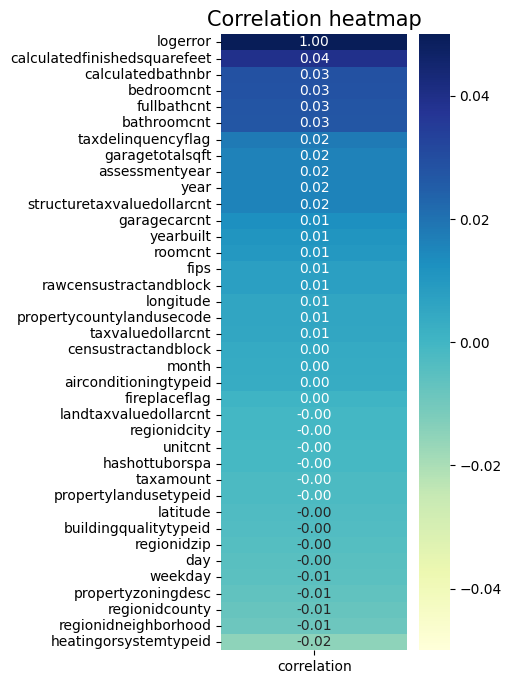

In [30]:
corr = pd.DataFrame(data.corr()['logerror'].sort_values(ascending = False)).rename(columns = {'logerror':'correlation'})

plt.figure(figsize = (3,8))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'YlGnBu')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

## モデル
1.pytorchを用いたNNによる線形回帰    
2.xgboostを用いた勾配木ブースティングよる線形回帰  


###1.pytorchを用いたNNによる線形回帰

In [ ]:
!pip install optuna

In [6]:
import optuna
from optuna.integration import PyTorchIgnitePruningHandler

MLPクラス

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, use_gpu=True):
        super(MLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.layers_dim = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        self._gpu = use_gpu and torch.cuda.is_available()
        self.eps = 1e-5
        self.num_features = num_features
        
    def build_model(self):
        for i, dim in enumerate(self.layers_dim):
            if i < len(self.layers_dim)-1:
                new_layer = nn.Linear(dim, self.layers_dim[i+1])
                nn.init.xavier_uniform_(new_layer.weight)
                self.layers.append(new_layer)
                bn_layer = nn.BatchNorm1d(self.layers_dim[i+1], eps=self.eps)
                self.layers.append(bn_layer)
            
            if i < len(self.layers_dim)-2:
                new_layer = nn.ReLU()
                self.layers.append(new_layer)
            
    def forward(self, X):
        self.build_model
        if self._gpu:
            self.layers.cuda()

        for layer in self.layers:
            X = layer(X)
        return X
            

In [ ]:
import os
os.cpu_count()

4

MyDatasetクラス  
前処理などを加えたカスタムされたデータセットを作成

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.X = data.drop('logerror', axis=1)
        self.y = data['logerror']
        
    def __len__(self):
        return len(self.X), len(self.y)

    def __getitem__(self, idx):
        processed_X = self.X
        processed_y = self.y
        return processed_X, processed_y
    

 PytorchRegressorクラス

In [33]:
class PytorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim=10, hidden_dims =[10, 10], output_dim=1,
                lr_rate=0.01, batch_size=128, use_gpu=True, frac=None, trial_stopper=True,
                num_epochs=10, n_kf=5, n_trials=10, n_startup_trials=5, n_warmup_steps=30, interval_steps=10):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.lr_rate = lr_rate
        self.batch_size = batch_size
        self.use_gpu = use_gpu
        self._gpu = self.use_gpu and torch.cuda.is_available()
        self.frac = frac
        self.trial_stopper = trial_stopper
        self.num_epochs = num_epochs
        self.n_kf = n_kf
        self.n_trials = n_trials
        self.is_pruner = is_pruner
        self.n_startup_trials = n_startup_trials
        self.n_warmup_steps = n_warmup_steps
        self.interval_steps = interval_steps
        self.pruner = None
        if self.is_pruner:
            self.pruner = optuna.pruners.MedianPruner(
                            n_startup_trials=self.n_startup_trials,
                            n_warmup_steps=self.n_warmup_steps, interval_steps=self.interval_steps)
        
        
        # # フレームごとに動的に追加したい属性を追加できる
        # args, _, _, values = inspect.getargvalues(inspect.currentframe())
        # values.pop("self")

        # for arg, val in values.items():
        #     setattr(self, arg, val)


    def objective(self, trial):
        self.lr_rate = trial.suggest_float('lr_rate', 1e-5, 1e-1, log=True)
        self.n_hidden = trial.suggest_int('n_hidden', 1, 5, log=False)
        self.hidden_dims = []
        for i in range(self.n_hidden):
            self.hidden_dims.append(trial.suggest_int('hidden_dim_'+str(i+1), 10, 100, log=True))
        self.alpha = trial.suggest_float('alpha', 1e-3, 1e-1, log=True)
        self._model = MLP(input_dim=self.input_dim, hidden_dims=self.hidden_dims, output_dim=self.output_dim)
        self._model.build_model()
        if self._gpu:
            self._model.cuda()
        
        kf = KFold(n_splits=self.n_kf, shuffle=True, random_state=42)
        loss_fn = nn.MSELoss(reduction='mean')
        optimizer = optim.Adam(self._model.parameters(), lr=self.lr_rate)
        val_loss_kf = []
        cv_cnt = 0
        
        for train_idx, val_idx in kf.split(self.X):
            if self.trail_stopper and trial.number >= 10:
                raise optuna.exceptions.TrialPruned()
            # if trial.number >= 10:
            #     raise optuna.exceptions.TrialPruned()
            else:
                pass

            if cv_cnt == 0:
                print('--------trail'+str(trial.number+1)+': Start--------')
            print('--------cv'+str(cv_cnt+1)+': Start--------')
            self._model.train()
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]

            torch_X_train = torch.from_numpy(X_train.values).float()
            torch_y_train = torch.from_numpy(y_train.values).float()
            torch_X_val = torch.from_numpy(X_val.values).float()
            torch_y_val = torch.from_numpy(y_val.values).float()

            torch_X_train.requires_grad_()
            torch_X_val.requires_grad_()
            torch_y_train.requires_grad_()
            torch_y_val.requires_grad_()
            
            if self._gpu:
                torch_X_train = torch_X_train.cuda()
                torch_X_val = torch_X_val.cuda()
                torch_y_train = torch_y_train.cuda()
                torch_y_val = torch_y_val.cuda()
            

            train = data_utils.TensorDataset(torch_X_train, torch_y_train)
            train_loader = data_utils.DataLoader(train, batch_size=self.batch_size, shuffle=True)
            for epoch in tqdm(range(self.num_epochs)):
                print('\n--------epoch'+str(epoch+1)+': Start--------')
                current_loss = 0
                
                for minibatch, target in train_loader:
                    y_pred = self._model(minibatch)
                    loss = loss_fn(y_pred, target.float().unsqueeze(1))
                    l2 = torch.tensor(0., requires_grad=True)
                    for w in self._model.parameters():
                        l2 = l2 + torch.norm(w, p=2)**2
                    loss += self.alpha/2 * l2.item()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    # 直近の損失
                    current_loss = loss.item()
                
                # optunaに途中結果を報告
                # minibatchごとに経過をリアルタイムに逐次報告したいならば、一段下げてネスト。
                # これはepochごとで報告 
                trial.report(current_loss, step=epoch)
                # 枝狩りのイベント発生したら早期終了
                if trial.should_prune():
                    print("epoch", epoch+1,"で打ち切り")
                    raise optuna.structs.TrialPruned()
                print('\n--------epoch'+str(epoch+1)+': Done--------')

            self._model.eval()
            val_loss = loss_fn(self._model(torch_X_val), torch_y_val.unsqueeze(1))
            val_loss_kf.append(val_loss.item())
            mean_val_loss = np.mean(val_loss_kf)
            print('--------cv'+str(cv_cnt+1)+': Done--------\n')
            cv_cnt += 1
        
        return mean_val_loss


    def fit(self, X, y, study_name, abs_path='/content/drive/MyDrive/kaggle/zillow_prize/opt_study/torch_save/'):
        
        self.X = X
        self.y = y
        # 学習データを部分的に使用する場合に使用
        if self.frac:
            self.X = X.sample(frac=self.frac, random_state=42)
            self.y = y.sample(frac=self.frac, random_state=42)

        file_name = study_name + '.db'
        self.study = optuna.create_study(study_name=study_name,
                                    storage='sqlite:///'+abs_path+file_name,
                                    direction="minimize",
                                    load_if_exists=True,
                                    pruner=self.pruner)
                                    # pruner=optuna.pruners.MedianPruner(
                                    # n_startup_trials=self.n_startup_trials, n_warmup_steps=self.n_warmup_steps, interval_steps=self.interval_steps))
        
        self.study.optimize(self.objective, n_trials=self.n_trials,
                    #    callbacks=[pruning_handler]
                    )
        print('---------ハイパラ探索完了---------')

        best_params = self.study.best_params
        self.lr_rate = best_params['lr_rate']
        self.n_hidden = best_params['n_hidden']
        self.hidden_dims = []
        for i in range(self.n_hidden):
            self.hidden_dims.append(best_params['hidden_dim_'+str(i+1)])
        self._model = MLP(input_dim=self.input_dim, hidden_dims=self.hidden_dims, output_dim=self.output_dim)
        self._model.build_model()
        if self._gpu:
            self._model.cuda()
        
        loss_fn = nn.MSELoss(reduction='mean')
        self.optimizer = optim.Adam(self._model.parameters(), lr=self.lr_rate)
        self.train_losses = []
        self.val_losses = []
        torch_X_train = torch.from_numpy(X.values).float()
        torch_y_train = torch.from_numpy(y.values).float()
        torch_X_train.requires_grad_()
        torch_y_train.requires_grad_()
        if self._gpu:
            torch_X_train = torch_X_train.cuda()
            torch_y_train = torch_y_train.cuda()

        train = data_utils.TensorDataset(torch_X_train, torch_y_train)
        train_loader = data_utils.DataLoader(train, batch_size=self.batch_size, shuffle=True)
        self._model.train()
        torch.backends.cudnn.benchmark = True
        print('---------学習開始---------')
        for epoch in tqdm(range(self.num_epochs)):
            print('\n--------epoch'+str(epoch+1)+': Start--------')
            train_loss = None
            for minibatch, target in train_loader:
                self.optimizer.zero_grad()
                y_pred = self._model(minibatch)
                train_loss = loss_fn(y_pred, target.float().unsqueeze(1))
                train_loss.backward()
                self.optimizer.step()
            self.train_losses.append(train_loss.item())
            print('\n--------epoch'+str(epoch+1)+' :Done--------')

        print('---------学習完了---------')
        return self


    def predict(self, X):
        torch_X = torch.from_numpy(X.values).float()
        if self._gpu:
            torch_X = torch_X.cuda()
        self._model.eval()
        y_pred = self._model(torch_X).cpu().detach().numpy()
        return y_pred


    def score(self, X, y):
        y = y.to_numpy()
        y_pred = self.predict(X)
        test_loss = mean_absolute_error(y, y_pred)
        return test_loss

    # def show_imortance(self,):
    #     # 特徴量の重要度を参照する
    #     # モデルベースか統計的手法かユースケースかで違ってくる
    #     total_weight = 0.0
    #     feature_importances = []
    #     for param in self._model.parameters():
    #         total_weights += torch.sum(torch.abs(param.data))
    #         feature_importances.append(torch.abs(param.data))

    # def re_fit(self, X, y, ratio=0.6):
    #     # fit()で学習後、特徴量の重要度を算出し、重要度の高い特徴量を指定した割合に絞ってさらに学習を行う
         
    #     return

    def save(self, file_name, abs_path='/content/drive/MyDrive/kaggle/zillow_prize/save_model/torch_save/'):
        checkpoint = {
            "model_state_dict": self._model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict()
        }
        torch.save(checkpoint, abs_path+file_name+'.pt')

In [ ]:
torch.cuda.device_count()

1

### 計算の開始

### 一回目
データのレコード数は元の半分で、特徴量は37個
エポック数は10、kfoldは5分割、optunaの試行回数は10回
チューニングするハイパラは、`alpha`: 正則化項パラメータ
`hidden_dim_x`: 隠れ層_xの次元
`lr_rate`: 学習率
`n_hidden`: 隠れ層の数

In [9]:
y = data['logerror']
X = data.drop('logerror', axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

Pytorchモデルの学習

In [ ]:
num_features=37
estimator = PytorchRegressor(input_dim=num_features, frac=0.5, num_epochs=10, n_kf=5, n_trials=10)

In [ ]:
study_name = 'opt_study_torch_230605_01'

In [ ]:
estimator.fit(X_train, y_train, study_name)

[I 2023-06-05 10:51:32,219] A new study created in RDB with name: opt_study230605_01


--------trail1: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:11<01:41, 11.22s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:18<01:11,  8.99s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:27<01:02,  8.90s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:35<00:51,  8.60s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:43<00:41,  8.39s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:51<00:33,  8.35s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:59<00:24,  8.20s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:07<00:16,  8.13s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:15<00:08,  8.15s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:23<00:00,  8.35s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
 10%|█         | 1/10 [00:08<01:12,  8.04s/it]


--------epoch1: Done--------

--------epoch2: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
 20%|██        | 2/10 [00:15<01:01,  7.63s/it]


--------epoch2: Done--------

--------epoch3: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
 30%|███       | 3/10 [00:22<00:52,  7.45s/it]


--------epoch3: Done--------

--------epoch4: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
 40%|████      | 4/10 [00:30<00:45,  7.66s/it]


--------epoch4: Done--------

--------epoch5: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
 50%|█████     | 5/10 [00:37<00:37,  7.56s/it]


--------epoch5: Done--------

--------epoch6: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
 60%|██████    | 6/10 [00:45<00:30,  7.69s/it]


--------epoch6: Done--------

--------epoch7: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
 70%|███████   | 7/10 [00:53<00:22,  7.55s/it]


--------epoch7: Done--------

--------epoch8: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
 80%|████████  | 8/10 [01:00<00:15,  7.60s/it]


--------epoch8: Done--------

--------epoch9: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
 90%|█████████ | 9/10 [01:08<00:07,  7.49s/it]


--------epoch9: Done--------

--------epoch10: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
100%|██████████| 10/10 [01:16<00:00,  7.60s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.36s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.15s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.06s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:33<00:50,  8.45s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.21s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:33,  8.42s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:58<00:25,  8.58s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:06<00:16,  8.34s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:14<00:08,  8.25s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:23<00:00,  8.34s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:09,  7.69s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:04,  8.03s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.04s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.12s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.16s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.08s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:56<00:24,  8.21s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.21s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.15s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.16s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:17,  8.60s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.07s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.24s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.18s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.28s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:33,  8.32s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.24s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:06<00:16,  8.35s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:14<00:08,  8.18s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:22<00:00,  8.25s/it]
[I 2023-06-05 10:58:24,937] Trial 0 finished with value: 3988.702449798584 and parameters: {'alpha': 0.008170871534114105, 'hidden_dim_1': 37, 'lr_rate': 1.8187350607661685e-05, 'n_hidden': 1}. Best is trial 0 with value: 3988.702449798584.



--------epoch10: Done--------
--------cv5: Done--------

--------trail2: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.42s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.16s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.04s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.19s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.23s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.11s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.13s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:04<00:15,  7.99s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:12<00:08,  8.00s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:20<00:00,  8.10s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:06,  7.42s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:00,  7.62s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.79s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.85s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.79s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:30,  7.65s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.78s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.81s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.84s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.82s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:05,  7.29s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:01,  7.63s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.84s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.81s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.92s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.92s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.91s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:03<00:15,  7.97s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.72s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.80s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:08,  7.60s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:00,  7.62s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.72s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:30<00:46,  7.72s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:39,  7.82s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.93s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.89s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.93s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.92s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.83s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:13,  8.12s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.06s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.13s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.18s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.18s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.13s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:56<00:24,  8.03s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:04<00:16,  8.09s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.14s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:20<00:00,  8.07s/it]
[I 2023-06-05 11:05:01,443] Trial 1 finished with value: 0.027567340806126595 and parameters: {'alpha': 0.01916320012524332, 'hidden_dim_1': 51, 'hidden_dim_2': 86, 'lr_rate': 0.008601336934850315, 'n_hidden': 2}. Best is trial 1 with value: 0.027567340806126595.



--------epoch10: Done--------
--------cv5: Done--------

--------trail3: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:17,  8.65s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:17<01:09,  8.72s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:25<01:00,  8.63s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:34<00:51,  8.66s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:43<00:43,  8.63s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:51<00:34,  8.61s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:00<00:25,  8.61s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:09<00:17,  8.67s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:17<00:08,  8.50s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:25<00:00,  8.60s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.42s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.08s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.19s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.27s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.27s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:33,  8.34s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.28s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:06<00:16,  8.30s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:14<00:08,  8.35s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:22<00:00,  8.26s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:14,  8.28s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:07,  8.42s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.08s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.20s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.32s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:33,  8.28s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.30s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.16s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.15s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:22<00:00,  8.23s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.36s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:06,  8.33s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:25<00:59,  8.55s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:33<00:50,  8.40s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:42<00:42,  8.43s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:50<00:33,  8.41s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:58<00:24,  8.33s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:06<00:16,  8.33s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:15<00:08,  8.40s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:23<00:00,  8.36s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:16,  8.51s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:06,  8.36s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.27s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:33<00:49,  8.29s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.31s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:50<00:33,  8.41s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:58<00:25,  8.40s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:06<00:16,  8.39s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:15<00:08,  8.31s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:23<00:00,  8.34s/it]
[I 2023-06-05 11:11:59,664] Trial 2 finished with value: 0.028047717362642288 and parameters: {'alpha': 0.009494205761313709, 'hidden_dim_1': 60, 'hidden_dim_2': 21, 'hidden_dim_3': 38, 'hidden_dim_4': 92, 'lr_rate': 0.02396656781667251, 'n_hidden': 4}. Best is trial 1 with value: 0.027567340806126595.



--------epoch10: Done--------
--------cv5: Done--------

--------trail4: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:09,  7.77s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.80s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:55,  7.94s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.90s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:40,  8.01s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.87s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.78s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.73s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:09<00:07,  7.63s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.77s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:12,  8.10s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.25s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.28s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.12s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.32s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:33,  8.34s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.20s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.17s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.04s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:20<00:00,  8.10s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.40s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:06,  8.25s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:58,  8.32s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:33<00:51,  8.55s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.27s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:32,  8.19s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.21s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.10s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:14<00:08,  8.21s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:22<00:00,  8.21s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:11,  7.97s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:06,  8.35s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.13s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.04s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.05s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.84s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:55<00:23,  7.82s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.62s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.62s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.82s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:05,  7.24s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:14<01:00,  7.54s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:22<00:52,  7.52s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.97s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:39,  7.89s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.80s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.99s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.97s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.85s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.82s/it]
[I 2023-06-05 11:18:37,198] Trial 3 finished with value: 11.462629122287035 and parameters: {'alpha': 0.008093631407566249, 'hidden_dim_1': 10, 'lr_rate': 0.09794690574561421, 'n_hidden': 1}. Best is trial 1 with value: 0.027567340806126595.



--------epoch10: Done--------
--------cv5: Done--------

--------trail5: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:09,  7.76s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.07s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.22s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.14s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:41,  8.25s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:33,  8.30s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.17s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.32s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:14<00:08,  8.38s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:22<00:00,  8.26s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:12,  8.11s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.14s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.25s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.19s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.10s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:32,  8.20s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.17s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:04<00:16,  8.02s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.13s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.14s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:13,  8.18s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:06,  8.35s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.14s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.25s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:41<00:41,  8.28s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:32,  8.13s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.22s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:06<00:16,  8.30s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:14<00:08,  8.27s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:22<00:00,  8.25s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:16,  8.47s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.19s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.22s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.11s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.15s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:49<00:32,  8.14s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:56<00:24,  8.04s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.13s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.23s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.13s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:14,  8.30s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.01s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.14s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.22s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.10s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.18s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.20s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.10s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.17s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.17s/it]
[I 2023-06-05 11:25:26,961] Trial 4 finished with value: 0.02782226577401161 and parameters: {'alpha': 0.0020474147553554397, 'hidden_dim_1': 10, 'hidden_dim_2': 30, 'hidden_dim_3': 60, 'lr_rate': 0.006725251405717391, 'n_hidden': 3}. Best is trial 1 with value: 0.027567340806126595.



--------epoch10: Done--------
--------cv5: Done--------

--------trail6: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:09,  7.73s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:03,  7.93s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:55,  7.87s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.96s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:40,  8.08s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:32,  8.04s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:56<00:24,  8.23s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.33s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:12<00:08,  8.19s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.15s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.40s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.05s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:57,  8.15s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.12s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.06s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.19s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:57<00:24,  8.23s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.24s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.25s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.17s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:11,  7.92s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.83s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.74s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:48,  8.03s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.90s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.89s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:55<00:23,  7.88s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.68s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:11<00:07,  7.97s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:19<00:00,  7.90s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:12,  8.00s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.23s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.07s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.14s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.20s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.14s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:56<00:24,  8.14s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:05<00:16,  8.18s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:13<00:08,  8.06s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:21<00:00,  8.11s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:07,  7.52s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:03,  7.97s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.10s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.90s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.99s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.95s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:55<00:23,  7.86s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:03<00:15,  7.94s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:11<00:07,  7.96s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:19<00:00,  7.99s/it]
[I 2023-06-05 11:32:10,699] Trial 5 finished with value: 0.02750311270356178 and parameters: {'alpha': 0.03976497826251383, 'hidden_dim_1': 10, 'hidden_dim_2': 24, 'hidden_dim_3': 20, 'lr_rate': 0.006738307049323921, 'n_hidden': 3}. Best is trial 5 with value: 0.02750311270356178.



--------epoch10: Done--------
--------cv5: Done--------

--------trail7: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:11,  7.98s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:01,  7.74s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.74s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:30<00:46,  7.71s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.78s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.88s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:22,  7.65s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:01<00:15,  7.70s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:09<00:07,  7.73s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.74s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:10,  7.84s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:00,  7.50s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.73s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:30<00:45,  7.60s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.64s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:45<00:30,  7.67s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:53<00:22,  7.60s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:01<00:15,  7.64s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:08<00:07,  7.57s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:16<00:00,  7.64s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:12,  8.02s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.80s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.08s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:48,  8.04s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.97s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.97s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:55<00:23,  7.98s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:03<00:15,  7.97s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:11<00:07,  7.98s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:19<00:00,  7.91s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:10,  7.84s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.77s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.80s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.79s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.84s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.80s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.69s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.75s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.91s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.80s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:08,  7.66s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:05,  8.18s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.85s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.94s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:38,  7.73s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.86s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:55<00:24,  8.00s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:03<00:15,  7.87s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:11<00:07,  7.90s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:19<00:00,  7.91s/it]
[I 2023-06-05 11:38:40,865] Trial 6 finished with value: 0.02744697071611881 and parameters: {'alpha': 0.019849384379051305, 'hidden_dim_1': 46, 'lr_rate': 0.0057191543748938605, 'n_hidden': 1}. Best is trial 6 with value: 0.02744697071611881.



--------epoch10: Done--------
--------cv5: Done--------

--------trail8: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:09,  7.73s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.78s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:53,  7.69s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:47,  7.87s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.77s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.78s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.81s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:16,  8.01s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:08,  8.01s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:19<00:00,  7.91s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:08,  7.62s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.76s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:53,  7.68s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:30<00:46,  7.73s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.88s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:30,  7.71s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.78s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.85s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.89s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.82s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:04,  7.12s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:02,  7.80s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:55,  7.86s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.83s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.72s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:45<00:30,  7.53s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:53<00:23,  7.74s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:01<00:15,  7.77s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:08<00:07,  7.56s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.72s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:12,  8.10s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:04,  8.12s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:54,  7.75s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.80s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:38,  7.73s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:30,  7.64s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:53<00:22,  7.53s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:01<00:15,  7.68s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:09<00:07,  7.66s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.73s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:10,  7.80s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:01,  7.68s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:55,  7.89s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.81s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.91s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.77s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.74s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.70s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:09<00:07,  7.65s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.77s/it]
[I 2023-06-05 11:45:10,635] Trial 7 finished with value: 0.02868625186383724 and parameters: {'alpha': 0.001571618489796501, 'hidden_dim_1': 97, 'lr_rate': 0.0003396924736716645, 'n_hidden': 1}. Best is trial 6 with value: 0.02744697071611881.



--------epoch10: Done--------
--------cv5: Done--------

--------trail9: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:16,  8.45s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:07,  8.43s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:25<01:00,  8.63s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:34<00:51,  8.58s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:42<00:42,  8.41s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:51<00:34,  8.54s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:59<00:25,  8.51s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:08<00:16,  8.49s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:16<00:08,  8.57s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:25<00:00,  8.54s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.37s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:07,  8.45s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:25<00:58,  8.42s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:33<00:50,  8.41s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:42<00:42,  8.49s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:50<00:34,  8.52s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:59<00:25,  8.45s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:07<00:16,  8.46s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:16<00:08,  8.49s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:24<00:00,  8.47s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:19,  8.79s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:17<01:09,  8.63s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:25<00:58,  8.40s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:33<00:50,  8.46s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:42<00:42,  8.45s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:50<00:33,  8.40s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:59<00:25,  8.54s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:07<00:16,  8.39s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:16<00:08,  8.41s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:24<00:00,  8.47s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:16,  8.47s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:17<01:10,  8.77s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:26<01:01,  8.81s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:34<00:51,  8.57s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:43<00:42,  8.55s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:51<00:34,  8.53s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:59<00:25,  8.43s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:08<00:17,  8.58s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:17<00:08,  8.66s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:26<00:00,  8.60s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:17,  8.64s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:17<01:08,  8.61s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:25<00:58,  8.35s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:34<00:51,  8.53s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:42<00:42,  8.60s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:51<00:34,  8.57s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:59<00:25,  8.47s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:08<00:17,  8.56s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:16<00:08,  8.45s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:25<00:00,  8.51s/it]
[I 2023-06-05 11:52:16,857] Trial 8 finished with value: 0.027452706545591354 and parameters: {'alpha': 0.006324170143963914, 'hidden_dim_1': 43, 'hidden_dim_2': 23, 'hidden_dim_3': 39, 'hidden_dim_4': 85, 'hidden_dim_5': 45, 'lr_rate': 0.0012076646566341106, 'n_hidden': 5}. Best is trial 6 with value: 0.02744697071611881.



--------epoch10: Done--------
--------cv5: Done--------

--------trail10: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:11,  7.90s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:01,  7.70s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:53,  7.70s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:30<00:45,  7.66s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.74s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:46<00:31,  7.77s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.79s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.88s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:09<00:07,  7.76s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:17<00:00,  7.73s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:11,  7.92s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:00,  7.56s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:22<00:53,  7.66s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:30<00:44,  7.43s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:37<00:37,  7.46s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:45<00:30,  7.55s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:52<00:21,  7.33s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [00:59<00:14,  7.34s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:06<00:07,  7.29s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:14<00:00,  7.42s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:07<01:10,  7.82s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:03,  7.91s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.09s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.75s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:39<00:39,  7.84s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.94s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:55<00:23,  7.81s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:03<00:15,  7.92s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.81s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:15,  8.40s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:16<01:03,  7.97s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:23<00:55,  7.86s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:31<00:46,  7.72s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:38<00:38,  7.71s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:47<00:31,  7.86s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:54<00:23,  7.71s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:02<00:15,  7.75s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:10<00:07,  7.79s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:18<00:00,  7.83s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:08<01:12,  8.10s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:15<01:03,  7.97s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:24<00:56,  8.12s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [00:32<00:49,  8.19s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [00:40<00:40,  8.01s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [00:48<00:32,  8.10s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [00:56<00:24,  8.04s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [01:04<00:16,  8.03s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [01:12<00:07,  8.00s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [01:19<00:00,  7.98s/it]
[I 2023-06-05 11:58:45,443] Trial 9 finished with value: 4.173435075581073 and parameters: {'alpha': 0.0022406627958408486, 'hidden_dim_1': 87, 'lr_rate': 0.00024885624541858426, 'n_hidden': 1}. Best is trial 6 with value: 0.02744697071611881.



--------epoch10: Done--------
--------cv5: Done--------

---------ハイパラ探索完了---------
---------学習開始---------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:36<05:31, 36.81s/it]


--------epoch1 :Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [01:13<04:56, 37.02s/it]


--------epoch2 :Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [01:51<04:20, 37.17s/it]


--------epoch3 :Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [02:27<03:41, 36.97s/it]


--------epoch4 :Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [03:04<03:04, 36.91s/it]


--------epoch5 :Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [03:41<02:27, 36.76s/it]


--------epoch6 :Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [04:17<01:49, 36.57s/it]


--------epoch7 :Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [04:54<01:13, 36.79s/it]


--------epoch8 :Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [05:31<00:36, 36.88s/it]


--------epoch9 :Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [06:08<00:00, 36.86s/it]


--------epoch10 :Done--------
---------学習完了---------


PytorchRegressor(frac=0.5, hidden_dims=[46], input_dim=37,
                 lr_rate=0.0057191543748938605)

ハイパラの表示  
`alpha`: 正則化項パラメータ  
`hidden_dim_x`: 隠れ層_xの次元  
`lr_rate`: 学習率  
`n_hidden`: 隠れ層の数

In [ ]:
estimator.study.best_params

{'alpha': 0.019849384379051305,
 'hidden_dim_1': 46,
 'lr_rate': 0.0057191543748938605,
 'n_hidden': 1}

スコアの算出

In [ ]:
estimator.score(X_test, y_test)

0.06989364277579643

学習したモデルの保存

In [ ]:
save_model_name = 'torch_model_230605_01'

In [ ]:
estimator.save(save_model_name)

参考として、本コンテストのPublicのトップスコアは0.06318、Privateのトップスコアは0.07408である。

一回目のハイパラ探索から学習までおおよそ一時間程度かかった。  
テスト誤差(スコア)は約0.069であった。Publicスコアとの差はかなり小さく精度のよいモデルを構築できた。  
正則化項パラメータは0.0198、隠れ層は[46]の1層、学習率は0.0057


### 二回目
二回目はデータ数を減らさず元のレコード数で行ってみる。

In [34]:
num_features=37
estimator = PytorchRegressor(input_dim=num_features, batch_size=512, num_epochs=10, n_kf=5, n_trials=50, n_startup_trials=5, n_warmup_steps=30, interval_steps=5)

In [35]:
study_name = 'opt_study_torch_230606_01'

In [36]:
estimator.fit(X_train, y_train, study_name)

[I 2023-06-06 05:19:29,197] A new study created in RDB with name: opt_study_torch_230606_01


--------trail1: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:18<02:44, 18.23s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:33<02:12, 16.59s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:49<01:54, 16.34s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:05<01:37, 16.23s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:22<01:21, 16.30s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:38<01:04, 16.18s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:54<00:48, 16.10s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:09<00:31, 16.00s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:25<00:15, 15.90s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:40<00:00, 16.09s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
 10%|█         | 1/10 [00:15<02:16, 15.21s/it]


--------epoch1: Done--------

--------epoch2: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
 20%|██        | 2/10 [00:30<02:02, 15.37s/it]


--------epoch2: Done--------

--------epoch3: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
 30%|███       | 3/10 [00:45<01:46, 15.26s/it]


--------epoch3: Done--------

--------epoch4: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
 40%|████      | 4/10 [01:01<01:31, 15.25s/it]


--------epoch4: Done--------

--------epoch5: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
 50%|█████     | 5/10 [01:16<01:17, 15.45s/it]


--------epoch5: Done--------

--------epoch6: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
 60%|██████    | 6/10 [01:32<01:01, 15.49s/it]


--------epoch6: Done--------

--------epoch7: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
 70%|███████   | 7/10 [01:48<00:46, 15.53s/it]


--------epoch7: Done--------

--------epoch8: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
 80%|████████  | 8/10 [02:03<00:30, 15.45s/it]


--------epoch8: Done--------

--------epoch9: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
 90%|█████████ | 9/10 [02:18<00:15, 15.44s/it]


--------epoch9: Done--------

--------epoch10: Start--------


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
100%|██████████| 10/10 [02:35<00:00, 15.58s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:21, 15.74s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:32<02:10, 16.29s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:48<01:53, 16.27s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:05<01:37, 16.32s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:21<01:21, 16.31s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:37<01:04, 16.17s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:52<00:47, 15.97s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:08<00:31, 15.87s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:24<00:15, 15.81s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:40<00:00, 16.01s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:16, 15.20s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.31s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.28s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:31, 15.26s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.39s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.39s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.34s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.46s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.39s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.40s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.54s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:32<02:09, 16.16s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:48<01:53, 16.26s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:04<01:36, 16.04s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:20<01:21, 16.28s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:37<01:04, 16.22s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:53<00:48, 16.20s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:09<00:32, 16.18s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:25<00:16, 16.07s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:40<00:00, 16.10s/it]
[I 2023-06-06 05:32:46,466] Trial 0 finished with value: 0.028046661242842674 and parameters: {'alpha': 0.031669455165797465, 'hidden_dim_1': 50, 'hidden_dim_2': 13, 'lr_rate': 0.0018203189802977378, 'n_hidden': 2}. Best is trial 0 with value: 0.028046661242842674.



--------epoch10: Done--------
--------cv5: Done--------

--------trail2: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:16<02:26, 16.30s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:32<02:09, 16.24s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:48<01:52, 16.04s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:04<01:36, 16.17s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:20<01:20, 16.06s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:36<01:04, 16.09s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:52<00:48, 16.04s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:07<00:31, 15.78s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:23<00:15, 15.70s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:38<00:00, 15.87s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.25s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.37s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.36s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.34s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:18, 15.63s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:02, 15.54s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.64s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.50s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.54s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.49s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.24s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.34s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:47, 15.32s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:31, 15.31s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.32s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.25s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:45, 15.29s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.30s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:17<00:15, 15.40s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.32s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.65s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.56s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.47s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.40s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:16, 15.37s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.31s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:45, 15.33s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.34s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.30s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.37s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.23s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.31s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:47, 15.35s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:31, 15.29s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.32s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.44s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:47, 15.78s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.70s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.90s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:36<00:00, 15.69s/it]
[I 2023-06-06 05:45:44,341] Trial 1 finished with value: 4211.846903038025 and parameters: {'alpha': 0.0010002566706903836, 'hidden_dim_1': 40, 'hidden_dim_2': 68, 'hidden_dim_3': 11, 'lr_rate': 1.2249666821620857e-05, 'n_hidden': 3}. Best is trial 0 with value: 0.028046661242842674.



--------epoch10: Done--------
--------cv5: Done--------

--------trail3: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.60s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:06, 15.78s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:47<01:50, 15.78s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:03<01:35, 15.85s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:19<01:19, 15.96s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:35<01:03, 15.96s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:50<00:47, 15.85s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:05<00:31, 15.56s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:22<00:15, 15.78s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:38<00:00, 15.82s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:16<02:27, 16.38s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:32<02:10, 16.32s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:48<01:51, 15.90s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:03<01:34, 15.82s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:19<01:19, 15.94s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:36<01:04, 16.02s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:51<00:47, 15.68s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:06<00:31, 15.72s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:22<00:15, 15.73s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:38<00:00, 15.80s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.48s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.41s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.53s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.48s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:18, 15.60s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.61s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:49<00:46, 15.67s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.62s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.66s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.58s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.25s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:00, 15.09s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:45, 15.05s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:30, 15.09s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.04s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.01s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:45<00:45, 15.02s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:00<00:29, 14.99s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:15<00:15, 15.02s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:30<00:00, 15.05s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:15, 15.10s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:01, 15.19s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.15s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:30, 15.05s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.07s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.01s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:45<00:45, 15.02s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:00<00:30, 15.00s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:15<00:15, 15.03s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:30<00:00, 15.06s/it]
[I 2023-06-06 05:58:37,826] Trial 2 finished with value: 0.03319524601101875 and parameters: {'alpha': 0.08569488967812783, 'hidden_dim_1': 93, 'lr_rate': 0.05116162926350771, 'n_hidden': 1}. Best is trial 0 with value: 0.028046661242842674.



--------epoch10: Done--------
--------cv5: Done--------

--------trail4: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:21, 15.76s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.53s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.50s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.52s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.52s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.59s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.51s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.51s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.51s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.54s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.66s/it]


--------epoch1: Done--------

--------epoch2: Start--------

--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.57s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.63s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.59s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.62s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:49<00:46, 15.60s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.62s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.54s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.58s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.62s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.42s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.41s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.34s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.45s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.42s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.40s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.46s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.45s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.44s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.48s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.55s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.53s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.48s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.54s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:01, 15.49s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.52s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:30, 15.48s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.47s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.51s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.57s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.59s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:49, 15.59s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.54s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.56s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:01, 15.49s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.51s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:30, 15.47s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.44s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.53s/it]
[I 2023-06-06 06:11:34,256] Trial 3 finished with value: 0.027659018710255622 and parameters: {'alpha': 0.005470608934498056, 'hidden_dim_1': 39, 'hidden_dim_2': 30, 'hidden_dim_3': 85, 'hidden_dim_4': 25, 'lr_rate': 0.003980736329832024, 'n_hidden': 4}. Best is trial 3 with value: 0.027659018710255622.



--------epoch10: Done--------
--------cv5: Done--------

--------trail5: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.27s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.41s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.37s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.45s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.37s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.34s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.38s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.44s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.41s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.41s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:18, 15.35s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.40s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.33s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:31, 15.29s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.39s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:01, 15.30s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.35s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.30s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:17<00:15, 15.31s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.34s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.26s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.37s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:47, 15.30s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.43s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.33s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:01, 15.28s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.37s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.30s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:17<00:15, 15.24s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:18, 15.41s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.44s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.35s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.35s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.44s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.42s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.41s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.41s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.40s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.41s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.22s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:01, 15.17s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.22s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:30, 15.11s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.19s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:01, 15.25s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.25s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.27s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.18s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:32<00:00, 15.22s/it]
[I 2023-06-06 06:24:21,706] Trial 4 finished with value: 0.028115705400705338 and parameters: {'alpha': 0.006512436241879552, 'hidden_dim_1': 37, 'hidden_dim_2': 56, 'hidden_dim_3': 15, 'lr_rate': 0.004752347503159379, 'n_hidden': 3}. Best is trial 3 with value: 0.027659018710255622.



--------epoch10: Done--------
--------cv5: Done--------

--------trail6: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.27s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.34s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.26s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.36s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.39s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.42s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.55s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:31, 15.54s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.52s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.44s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:18, 15.34s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:04, 15.50s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.47s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.43s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.43s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.44s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.47s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.46s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.55s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.49s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.59s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.30s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.37s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.42s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.32s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.38s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:45, 15.31s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.26s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.34s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.36s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:16, 15.19s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.35s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.27s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.35s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.30s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.23s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.25s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.24s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:17<00:15, 15.29s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:32<00:00, 15.30s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.47s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.48s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.43s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.42s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.35s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.34s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:45, 15.29s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.28s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.33s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.34s/it]
[I 2023-06-06 06:37:11,402] Trial 5 finished with value: 0.027543491497635842 and parameters: {'alpha': 0.05033445829898961, 'hidden_dim_1': 34, 'hidden_dim_2': 36, 'hidden_dim_3': 18, 'lr_rate': 0.001274973642586467, 'n_hidden': 3}. Best is trial 5 with value: 0.027543491497635842.



--------epoch10: Done--------
--------cv5: Done--------

--------trail7: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.32s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:03, 15.39s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.43s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.46s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.34s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.23s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:46, 15.44s/it]


--------epoch7: Done--------

--------epoch8: Start--------

--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.30s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.34s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.55s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.55s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.45s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.45s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.51s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:02, 15.51s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.49s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.45s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.36s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:34<00:00, 15.47s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:16, 15.12s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:01, 15.22s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.17s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.19s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.22s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.20s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.16s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.17s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.11s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.17s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:15, 15.01s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:00, 15.02s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:45, 15.07s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:30, 15.03s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.12s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.09s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:45<00:45, 15.13s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:00<00:30, 15.11s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:15<00:15, 15.11s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.10s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:15, 15.10s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.37s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.21s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.17s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.21s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.16s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.22s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.20s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.15s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.19s/it]
[I 2023-06-06 06:49:54,453] Trial 6 finished with value: 0.027560819685459138 and parameters: {'alpha': 0.011287349336481498, 'hidden_dim_1': 58, 'hidden_dim_2': 22, 'lr_rate': 0.0049301351292635074, 'n_hidden': 2}. Best is trial 5 with value: 0.027543491497635842.



--------epoch10: Done--------
--------cv5: Done--------

--------trail8: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.53s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:05, 15.63s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:49, 15.57s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.50s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.53s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.55s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.51s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.51s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.60s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.55s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.62s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:05, 15.67s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.53s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.51s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.56s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.53s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.58s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.53s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.58s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.56s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.53s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.61s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:49, 15.59s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.51s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.58s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.68s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:49<00:46, 15.58s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.62s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.58s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.60s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:18, 15.38s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.53s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.54s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:33, 15.54s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:17, 15.56s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.53s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:48<00:46, 15.58s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:04<00:31, 15.55s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:19<00:15, 15.51s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:35<00:00, 15.56s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:20, 15.57s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:05, 15.70s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:47<01:50, 15.72s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:34, 15.69s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:18<01:18, 15.68s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:33<01:02, 15.61s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:49<00:46, 15.65s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:05<00:31, 15.57s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:20<00:15, 15.60s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:36<00:00, 15.62s/it]
[I 2023-06-06 07:02:53,782] Trial 7 finished with value: 0.02789268270134926 and parameters: {'alpha': 0.0013092464139284228, 'hidden_dim_1': 10, 'hidden_dim_2': 27, 'hidden_dim_3': 45, 'hidden_dim_4': 21, 'hidden_dim_5': 62, 'lr_rate': 0.012084402913676446, 'n_hidden': 5}. Best is trial 5 with value: 0.027543491497635842.



--------epoch10: Done--------
--------cv5: Done--------

--------trail9: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:18, 15.39s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:01, 15.19s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.25s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.22s/it]


--------epoch4: Done--------

--------epoch5: Start--------

--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.21s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.18s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.16s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.19s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.19s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:21, 15.77s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:31<02:04, 15.62s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:48, 15.44s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:02<01:32, 15.47s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:17<01:16, 15.36s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.33s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:45, 15.31s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:02<00:30, 15.25s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.33s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.37s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:19, 15.49s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.34s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:46<01:47, 15.33s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:32, 15.37s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.37s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:32<01:01, 15.39s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:47<00:45, 15.33s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:03<00:30, 15.39s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:18<00:15, 15.40s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:33<00:00, 15.37s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:16, 15.18s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:00, 15.10s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:45, 15.10s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:30, 15.11s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.07s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.12s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:45<00:45, 15.03s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:00<00:30, 15.09s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:15<00:15, 15.04s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:30<00:00, 15.08s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:16, 15.22s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:00, 15.08s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:45, 15.05s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.18s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.10s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.09s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:45<00:45, 15.11s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.15s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.11s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.11s/it]
[I 2023-06-06 07:15:35,315] Trial 8 finished with value: 0.07757483385503292 and parameters: {'alpha': 0.0011274289484559672, 'hidden_dim_1': 27, 'lr_rate': 0.00017643862988383688, 'n_hidden': 1}. Best is trial 5 with value: 0.027543491497635842.



--------epoch10: Done--------
--------cv5: Done--------

--------trail10: Start--------
--------cv1: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.32s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:02, 15.33s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:47, 15.31s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:01<01:31, 15.22s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:15, 15.16s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.20s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.16s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.17s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.12s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.17s/it]



--------epoch10: Done--------
--------cv1: Done--------

--------cv2: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.22s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:00, 15.12s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.19s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.18s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.31s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:01, 15.26s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.26s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.21s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:17<00:15, 15.23s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:32<00:00, 15.22s/it]



--------epoch10: Done--------
--------cv2: Done--------

--------cv3: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:14<02:14, 14.96s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:00, 15.11s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:45, 15.11s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:30, 15.07s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.08s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.08s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:45<00:45, 15.16s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:00<00:30, 15.12s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:15<00:15, 15.08s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.11s/it]



--------epoch10: Done--------
--------cv3: Done--------

--------cv4: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:17, 15.23s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:01, 15.20s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.23s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.23s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:16<01:16, 15.30s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:31<01:00, 15.20s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.23s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.20s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:17<00:15, 15.22s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:32<00:00, 15.22s/it]



--------epoch10: Done--------
--------cv4: Done--------

--------cv5: Start--------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:15<02:15, 15.04s/it]


--------epoch1: Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:30<02:01, 15.13s/it]


--------epoch2: Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [00:45<01:46, 15.18s/it]


--------epoch3: Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:00<01:31, 15.20s/it]


--------epoch4: Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:15<01:15, 15.14s/it]


--------epoch5: Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [01:30<01:00, 15.08s/it]


--------epoch6: Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [01:46<00:45, 15.17s/it]


--------epoch7: Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [02:01<00:30, 15.13s/it]


--------epoch8: Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [02:16<00:15, 15.16s/it]


--------epoch9: Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [02:31<00:00, 15.15s/it]
[I 2023-06-06 07:28:14,503] Trial 9 finished with value: 0.027879615873098375 and parameters: {'alpha': 0.0022588104857721274, 'hidden_dim_1': 84, 'hidden_dim_2': 49, 'lr_rate': 0.023958889147395062, 'n_hidden': 2}. Best is trial 5 with value: 0.027543491497635842.



--------epoch10: Done--------
--------cv5: Done--------



[I 2023-06-06 07:28:14,758] Trial 10 pruned. 
[I 2023-06-06 07:28:14,972] Trial 11 pruned. 
[I 2023-06-06 07:28:15,225] Trial 12 pruned. 
[I 2023-06-06 07:28:15,450] Trial 13 pruned. 
[I 2023-06-06 07:28:15,680] Trial 14 pruned. 
[I 2023-06-06 07:28:15,962] Trial 15 pruned. 
[I 2023-06-06 07:28:16,153] Trial 16 pruned. 
[I 2023-06-06 07:28:16,392] Trial 17 pruned. 
[I 2023-06-06 07:28:16,649] Trial 18 pruned. 
[I 2023-06-06 07:28:16,904] Trial 19 pruned. 
[I 2023-06-06 07:28:17,190] Trial 20 pruned. 
[I 2023-06-06 07:28:17,480] Trial 21 pruned. 
[I 2023-06-06 07:28:17,768] Trial 22 pruned. 
[I 2023-06-06 07:28:18,062] Trial 23 pruned. 
[I 2023-06-06 07:28:18,322] Trial 24 pruned. 
[I 2023-06-06 07:28:18,528] Trial 25 pruned. 
[I 2023-06-06 07:28:18,747] Trial 26 pruned. 
[I 2023-06-06 07:28:18,974] Trial 27 pruned. 
[I 2023-06-06 07:28:19,220] Trial 28 pruned. 
[I 2023-06-06 07:28:19,455] Trial 29 pruned. 
[I 2023-06-06 07:28:19,740] Trial 30 pruned. 
[I 2023-06-06 07:28:19,943] Trial 

---------ハイパラ探索完了---------
---------学習開始---------


  0%|          | 0/10 [00:00<?, ?it/s]


--------epoch1: Start--------


 10%|█         | 1/10 [00:23<03:33, 23.70s/it]


--------epoch1 :Done--------

--------epoch2: Start--------


 20%|██        | 2/10 [00:47<03:08, 23.51s/it]


--------epoch2 :Done--------

--------epoch3: Start--------


 30%|███       | 3/10 [01:10<02:43, 23.43s/it]


--------epoch3 :Done--------

--------epoch4: Start--------


 40%|████      | 4/10 [01:33<02:19, 23.29s/it]


--------epoch4 :Done--------

--------epoch5: Start--------


 50%|█████     | 5/10 [01:56<01:56, 23.21s/it]


--------epoch5 :Done--------

--------epoch6: Start--------


 60%|██████    | 6/10 [02:19<01:32, 23.16s/it]


--------epoch6 :Done--------

--------epoch7: Start--------


 70%|███████   | 7/10 [02:42<01:09, 23.10s/it]


--------epoch7 :Done--------

--------epoch8: Start--------


 80%|████████  | 8/10 [03:05<00:46, 23.09s/it]


--------epoch8 :Done--------

--------epoch9: Start--------


 90%|█████████ | 9/10 [03:28<00:22, 22.96s/it]


--------epoch9 :Done--------

--------epoch10: Start--------


100%|██████████| 10/10 [03:51<00:00, 23.14s/it]


--------epoch10 :Done--------
---------学習完了---------


PytorchRegressor(batch_size=512, hidden_dims=[34, 36, 18], input_dim=37,
                 interval_steps=5, lr_rate=0.001274973642586467, n_trials=50)

ハイパラの表示  
`alpha`: 正則化項パラメータ  
`hidden_dim_x`: 隠れ層_xの次元  
`lr_rate`: 学習率  
`n_hidden`: 隠れ層の数

In [37]:
estimator.study.best_params

{'alpha': 0.05033445829898961,
 'hidden_dim_1': 34,
 'hidden_dim_2': 36,
 'hidden_dim_3': 18,
 'lr_rate': 0.001274973642586467,
 'n_hidden': 3}

スコアの算出

In [38]:
estimator.score(X_test, y_test)

0.0697630265550083

学習したモデルの保存

In [39]:
save_model_name = 'torch_model_230606_01'

In [40]:
estimator.save(save_model_name)

### 2.xgboostを用いたGBDTよる線形回帰

In [42]:
class CustomXGBReg(BaseEstimator, RegressorMixin):
    def __init__(self, num_boost_round=10, n_fold=5, n_trials=50,n_startup_trials=10, n_warmup_steps=30, interval_steps=5):
    # def object()のハイパラ
        # general, bosster, learning, command line 各パラメータを設定する
        self.base_params = {
        # ★general parameters
        'booster': 'gbtree',

        #-----------------------------------------------------------------------'
        # ★booster parameters
        'tree_method': 'gpu_hist',

        # 構造上の問題でdef object()内に直接書く
            # # 学習率
            # 'eta': trial.suggest_float('lr_rate', 1e-4, 1e-1, log=True),
            # # 決定木の深さの最大値
            # 'max_depth': trial.suggest_int('max_depth', 3, 8),
            # # 決定木の葉の重みの下限
            # 'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
            # # L1正則化項
            # 'alpha': trial.suggest_float('alpha', 0, 10),
            # # L2正則化項
            # 'lambda': trial.suggest_float('alpha', 0, 10),
        # 決定木の葉の追加におけるペナルティ
        # 分割の前後の評価指標の差がgammaを超える場合にのみ、その分割が行われる。
        # 'gamma':,
        #-----------------------------------------------------------------------'
        # ★learning parameters
        'objective': 'reg:squarederror',
        #緩めの評価ならmae
        'eval_metric': 'rmse'}
        
        self.num_boost_round = num_boost_round
        self.nfold = n_fold
        self.stratified = False
        
    #　def fit()のハイパラ
        self.n_trials = n_trials
        self.load_if_exists = True
        self.pruner = optuna.pruners.MedianPruner(
                                        n_startup_trials=n_startup_trials, n_warmup_steps=n_warmup_steps, interval_steps=interval_steps)

    def objective(self, trial):
        d_train = xgb.DMatrix(self.X, label=self.y, nthread=-1)
        trial_params = {
            # 学習率
            'eta': trial.suggest_float('eta', 1e-4, 1e-1, log=True),
            # 決定木の深さの最大値
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            # 決定木の葉の重みの下限
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 100, log=True),
            # L1正則化項
            # 'alpha': trial.suggest_float('alpha', 0, 10),
            # L2正則化項
            'lambda': trial.suggest_float('alpha', 1e-4, 1e-1)
        }
        params = self.base_params | trial_params

        kf = KFold(n_splits=self.nfold, shuffle=True, random_state=0)
        folds = [(train_index, test_index) for train_index, test_index in kf.split(self.X)]
        cv_result = xgb.cv(params=params,
                        dtrain=d_train, num_boost_round=self.num_boost_round,
                        stratified=self.stratified, folds=folds)
                        # metrics=(),obj=None, feval=None, maximize=None,
                        # early_stopping_rounds=5, fpreproc=None,
                        # as_pandas=True, verbose_eval=None,
                        # show_stdv=True, seed=0, callbacks=None,
                        # shuffle=True, custom_metric=None
                        
        score = cv_result['test-{}-mean'.format(self.base_params["eval_metric"])].min()
        return score

    def fit(self, X, y, study_name, abs_path='/content/drive/MyDrive/kaggle/zillow_prize/opt_study/xgb_save/'):
        self.X, self.y = X, y
        self.dtrain = xgb.DMatrix(self.X, self.y)
        file_name = study_name + '.db'
        self.study = optuna.create_study(study_name=study_name,
                                    storage='sqlite:///'+abs_path+file_name,
                                    direction="minimize",
                                    load_if_exists=self.load_if_exists,
                                    pruner=self.pruner)
        
        self.study.optimize(self.objective, n_trials=self.n_trials)
        best_params = self.study.best_params
        self._model = xgb.train(best_params, dtrain=self.dtrain, num_boost_round=self.num_boost_round)
        
        # return self

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        y_pred = self._model.predict(dtest)

        return y_pred

    def socre(self, X, y):
        y_pred = self.predict(X)
        test_loss = mean_absolute_error(y, y_pred)
        
        return test_loss
    
    def save(self, file_name, abs_path='/content/drive/MyDrive/kaggle/zillow_prize/save_model/xgb_save/'):
        self._model.save_model(abs_path+file_name+'.json')


### 計算の開始

### 一回目
決定木の本数は50本、kfoldの分割数は5、optunaの試行回数は100  
チューニングするハイパラは、`alpha`:正則化項パラメータ,`eta`:学習率,
 `max_depth`:木の深さ,
 `min_child_weight`:決定木の葉の重みの下限

XGBモデルの学習

In [51]:
estimator_xgb = CustomXGBReg(num_boost_round=50, n_fold=5, n_trials=100)

In [52]:
study_name = 'opt_study_xgb_230606_01'

In [53]:
estimator_xgb.fit(X_train, y_train, study_name)

[I 2023-06-06 08:16:14,159] A new study created in RDB with name: opt_study_xgb_230606_01
[I 2023-06-06 08:16:15,273] Trial 0 finished with value: 0.46477350608313744 and parameters: {'alpha': 0.09623823875799113, 'eta': 0.002255106473792779, 'max_depth': 3, 'min_child_weight': 15}. Best is trial 0 with value: 0.46477350608313744.
[I 2023-06-06 08:16:16,743] Trial 1 finished with value: 0.505488375249375 and parameters: {'alpha': 0.03733000129058287, 'eta': 0.0003554532742344251, 'max_depth': 7, 'min_child_weight': 29}. Best is trial 0 with value: 0.46477350608313744.
[I 2023-06-06 08:16:19,189] Trial 2 finished with value: 0.4991078653707195 and parameters: {'alpha': 0.039423105226610994, 'eta': 0.0006401084799773185, 'max_depth': 11, 'min_child_weight': 71}. Best is trial 0 with value: 0.46477350608313744.
[I 2023-06-06 08:16:24,528] Trial 3 finished with value: 0.2990400530985871 and parameters: {'alpha': 0.09218532001532606, 'eta': 0.013386432212128731, 'max_depth': 14, 'min_child_

スコアの計算

In [54]:
estimator_xgb.socre(X_test, y_test)

0.06980939081725351

ハイパラの表示

In [48]:
estimator_xgb.study.best_params

{'alpha': 0.09243005807389802,
 'eta': 0.027247952584473187,
 'max_depth': 12,
 'min_child_weight': 59}

xgbモデルの保存

In [55]:
file_name = 'xgb_model_230606_01'

In [56]:
estimator_xgb.save(file_name)

In [49]:
cd /content/drive/MyDrive/kaggle/zillow_prize/opt_study/xgb_save/

/content/drive/MyDrive/kaggle/zillow_prize/opt_study/xgb_save


# まとめ
pytorchによるNNのモデル、xgboostのGBDTモデルはともにスコアは0.069程度になった。NNモデルは、計算リソースの制約上、これ以上深追いはしなかったが、ハイパラ探索のトライアルや学習回数を重ねればさらにスコアをよくできると推測できる。弱点としては、計算時間が多くなることである。効率的にモデルを学習するのに高速化やモデルの複雑性を抑えるなどで工夫する必要性があるだろう。GBDTモデルは、多数の決定木でトライアル回数を多く回しても短時間でNNモデルと同等の精度を実現できた。非常に実用的な手法である。

# 今後の課題
・統計学を中心とした数学とアルゴリズムのより高度な知識を深める   
・論文をサーベイし、実装するスキルを身につける    
・各コンペ(kaggle、atcoderなど)で経験を積む    
・モデル以上にデータの前加工が重要になる場合があるので、実践的で有用なメソッドを学ぶ  
・海外のエンジニアとのレビューでコミュニケーションをとるための英語力の向上  
・自分の得意なドメイン領域を複数開拓する  
・機械学習の実装をサービスに落とし込む  
・環境構築(AWS、Dockerなど)について学び、独自の環境でデプロイし実験できるようにする  
・高速化に関連したフレームワーク(rapids、daskなど)の知識を深める  
・余裕があれば、自前の機械学習用のデスクトップを用意したい  


In [ ]:
特徴量重要度について考察
枝狩りについてxgb